# Pokemon data
- 포켓몬스터 1세대 ~ 7세대 포켓몬 도감
- 801row * 41column
- kaggle에 올라온 데이터의 출처는 http://pokemon.wikia.com/wiki 로 예상
- 현재까지 나온 모든 포켓몬이 존재하는 데이터 => <strong><font color = "red">모집단</strong>
---

# 목차
1. Data overview
2. EDA
    - 세대(generation)
    - 포켓몬 타입(type1, type2)
    - 포켓몬 분류(classification)
    - 능력치(ability)
    - 상성 (against)
    - 포획률(capture_rate)
    - 경험치(experience_growth) 
3. Model
    - 데이터 전처리
    - 특징 선택(feature selection)
    - 모델 생성
        - Logistic Regression
        - Support Vector Machine
        - Decision Tree
        - Random Forest
4. 결론

## 분석 주제
- 일반 포켓몬과 전설의 포켓몬 차이 비교(시각화, 통계분석)
- 전설의 포켓몬을 분류하는 모델 생성(머신러닝)

---

# 컬럼 한글 설명
- is_legendary: 전설 유무
- generation: 포켓몬 세대
- pokedex_number: 포켓몬 도감 번호
- percentage_male: 포켓몬 성비(남성)
- type1: 포켓몬 타입 메인
- type2: 포켓몬 타입 서브
- classification: 포켓몬 분류
- height_m: 포켓몬 키
- weight_kg: 포켓몬 몸무게
- capture_rate: 3부터 255사이의 포획률, 이 포획률이 낮을수록 잡기 어려움
- base_egg_steps: 포켓몬 교배시 부화 걸음수
- abilities: 특성 , 숨겨진 특성
- experience_growth: Lv100 경험치 양
- base_happiness: 기초 친밀도
- against_?: 방어상성(18개 변수)

### 종족값
- hp: 체력
- attack: 공격
- defense: 방어
- sp_attack: 특수공격
- sp_defense: 특수방어
- speed: 스피드
- base total : 종족값 총 합계

# 데이터 문제점
### 1. 구분자가 콤마(,)로 되어 있으며, 일본어가 존재 => data load시에 column이 밀림
   - 콤마(,)를 |로 변경
   - abilities에 있는 ,들을 제외하고 40*802 = 32080의 ,를 |로 교체
   - row 개수는 801개 + header = 802<br />각 column 별로 존재하는 구분자 ,의 개수는 40개 <br />40*802 = 32080개의 ,를 |로 교체

### 2. 포켓몬 이름 : 일본어, 영어
- 우리는 한국인입니다. 
- 포켓몬 도감 번호 순서대로 데이터가 정렬되어 있다.
- http://ko.pokemon.wikia.com/wiki/%EC%A0%84%EA%B5%AD%EB%8F%84%EA%B0%90 에서 한국이름 매칭

### 3. NA 존재 (4개)
- height, kg => 20개 홈페이지(출처) 참조해서 채움
- type2 => 서브 타입이 없는 포켓몬도 있다. 
- percentage_male  => 무성인 포켓몬 존재

---
### 잘 정리된 table은 분석하기에도 좋다. 
### 엑셀을 활용하여 위 3가지 문제점을 해결한 데이터 : pokemon_analysis

## 0. setting

In [1]:
set.seed(1710)

## library
library(dplyr)
library(ggplot2)
library(gridExtra)
library(randomForest)
library(caret)
library(e1071)
library(kernlab)
library(car)
library(rpart)

## fuction
# type 변환
to.factors <- function(df, variables){
  for (variable in variables){
    df[[variable]] <- as.factor(df[[variable]])
  }
  return(df)
}

# type 변환
to.chars <- function(df, variables){
  for (variable in variables){
    df[[variable]] <- as.character(df[[variable]])
  }
  return(df)
}

# 표준화
scale.features <- function(df, variables){
  for (variable in variables){
    df[[variable]] <- scale(df[[variable]], center = T, scale = T)
  }
  return(df)
}

# RF importance
feature.selection <- function(num.iters=20, feature.vars, class.var){
  variable.sizes <- 1:10
  control <- rfeControl(functions = rfFuncs, method = "cv", 
                        verbose = FALSE, returnResamp = "all", 
                        number = num.iters)
  results.rfe <- rfe(x = feature.vars, y = class.var, 
                     sizes = variable.sizes, 
                     rfeControl = control)
  return(results.rfe)
}


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:ggplot2':

    margin

The following object is masked from 'package:dplyr':

    combine

Loading required package: lattice

Attaching package: 'kernlab'

The following object is masked from 'package:ggplot2':

    alpha


Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode



---
## 1. Data overview
- 데이터 형태 변환
- captreu_rate : 30(Meteorite)255(Core)으로 입력되어 있는 데이터는 30으로 변경<br />hp가 50%이하일때 core 상태로 변하며 포획률이 255로 변경되는 포켓몬(메테노)

In [2]:
pokemon <- read.csv(file = "data/pokemon_analysis.csv",
                    header = TRUE)

# data type
factorVars <- c("percentage_male","is_legendary",
                "generation","experience_growth",
                "percentage_male","base_egg_steps",
                "base_happiness")
charVars <- c("name","abilities")

pokemon <- to.factors(pokemon, factorVars)
pokemon <- to.chars(pokemon, charVars)

# 포켓몬 메테노 포획률 30 (Meteorite)255 (Core) : 30으로 변경
pokemon[pokemon[, "capture_rate"] == "30 (Meteorite)255 (Core)", ]$capture_rate = 30 
pokemon$capture_rate <- as.numeric(pokemon$capture_rate)

glimpse(pokemon)

Observations: 801
Variables: 40
$ is_legendary      <fctr> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ generation        <fctr> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ pokedex_number    <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15...
$ name              <chr> "이상해씨", "이상해풀", "이상해꽃", "파이리", "리자드", "리자몽", "꼬부기...
$ classfication     <fctr> Seed Pokemon, Seed Pokemon, Seed Pokemon, Lizard...
$ type1             <fctr> grass, grass, grass, fire, fire, fire, water, wa...
$ type2             <fctr> poison, poison, poison, , , flying, , , , , , fl...
$ abilities         <chr> "Overgrow,Chlorophyll", "Overgrow,Chlorophyll", "...
$ hp                <int> 45, 60, 80, 39, 58, 78, 44, 59, 79, 45, 50, 60, 4...
$ attack            <int> 49, 62, 100, 52, 64, 104, 48, 63, 103, 30, 20, 45...
$ defense           <int> 49, 63, 123, 43, 58, 78, 65, 80, 120, 35, 55, 50,...
$ sp_attack         <int> 65, 80, 122, 60, 80, 159, 50, 65, 135, 20, 25, 90...
$ sp_defense        

---
## 2. EDA

In [3]:
# Data split
# 일반 포켓몬
normal <- pokemon %>% 
  filter(is_legendary == 0)

# 전설의 포켓몬
legend <- pokemon %>% 
  filter(is_legendary == 1)

## 1) 세대(generation)
### 1-1) 일반 포켓몬 세대별 개체수

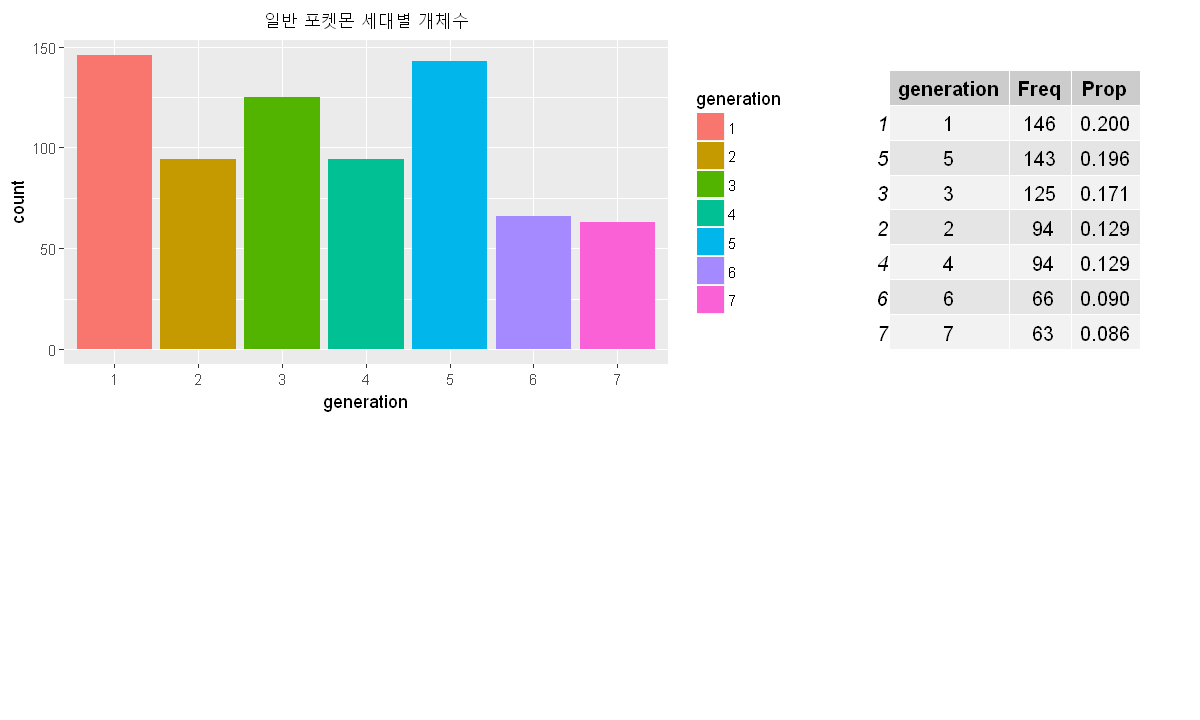

In [4]:
# 그림 크기 조절
options(repr.plot.width=10, repr.plot.height=6)

# barplot
p1_1 <- normal %>% 
  ggplot(aes(generation, fill = generation)) + 
  geom_bar() + 
  ggtitle("일반 포켓몬 세대별 개체수") +
  theme(plot.title = element_text(hjust = 0.5))

# table
df1 <- data.frame(table(normal$generation))
colnames(df1) <- c("generation", "Freq")
df2 <- data.frame(round(prop.table(table(normal$generation)),3))
colnames(df2) <- c("generation", "Prop")
df <- merge(df1, df2, by = "generation")
ndf <- df[order(-df$Freq),]
t1_1 <- tableGrob(ndf)

grid.arrange(p1_1, t1_1, ncol = 2, widths = c(6,3), heights = c(7,5))

* 일반 포켓몬 개체수는 1,5 세대가 많고 6,7세대가 작다.

---
### 1-2) 전설의 포켓몬 세대별 개체수

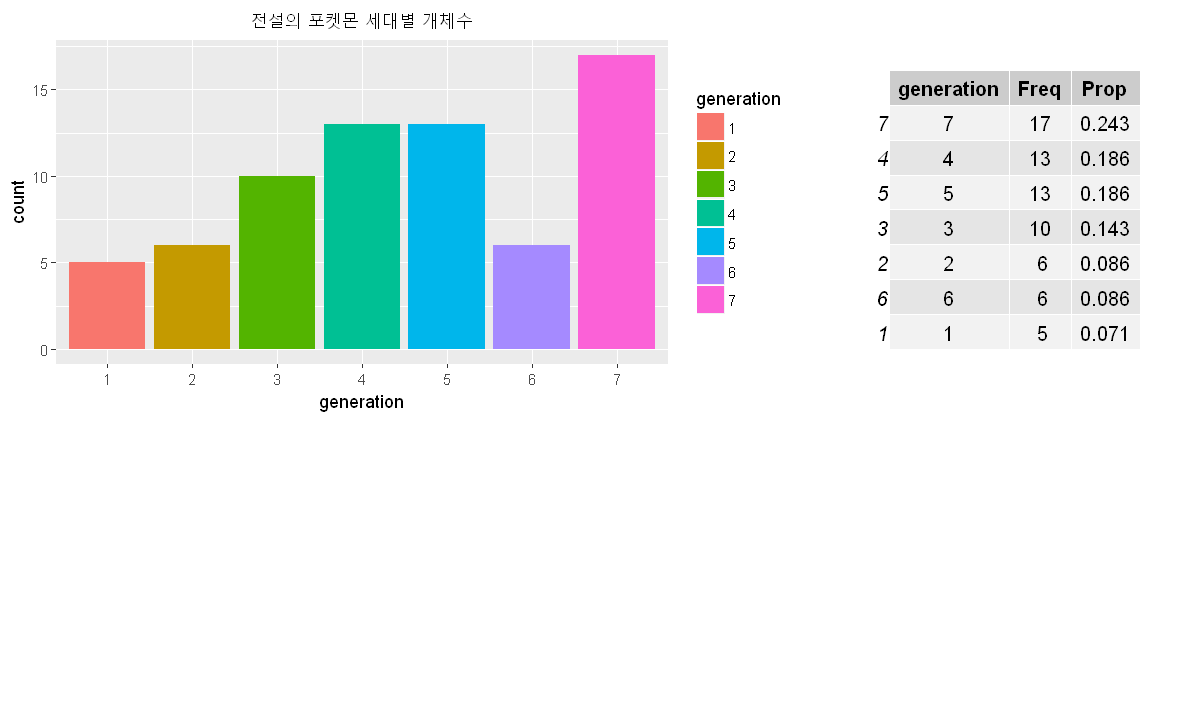

In [5]:
# barplot
p1_2 <- legend %>% 
  filter(is_legendary == 1) %>% 
  ggplot(aes(generation, fill = generation)) +
  geom_bar() + 
  ggtitle("전설의 포켓몬 세대별 개체수") +
  theme(plot.title = element_text(hjust = 0.5))

# table
df1 <- data.frame(table(legend$generation))
colnames(df1) <- c("generation", "Freq")
df2 <- data.frame(round(prop.table(table(legend$generation)),3))
colnames(df2) <- c("generation", "Prop")
df <- merge(df1, df2, by = "generation")
ndf <- df[order(-df$Freq),]
t1_2 <- tableGrob(ndf)
  
grid.arrange(p1_2, t1_2, ncol = 2, widths = c(6,3), heights = c(7,5))

* 전설의 포켓몬은 일반 포켓몬에 비해 1세대 개체수가 가장 작고 7세대 개체수가 가장 많다.

---
### 1-3) 전체 포켓몬 중 세대별로 일반 포켓몬과 전설의 포켓몬이 차지하는 비율

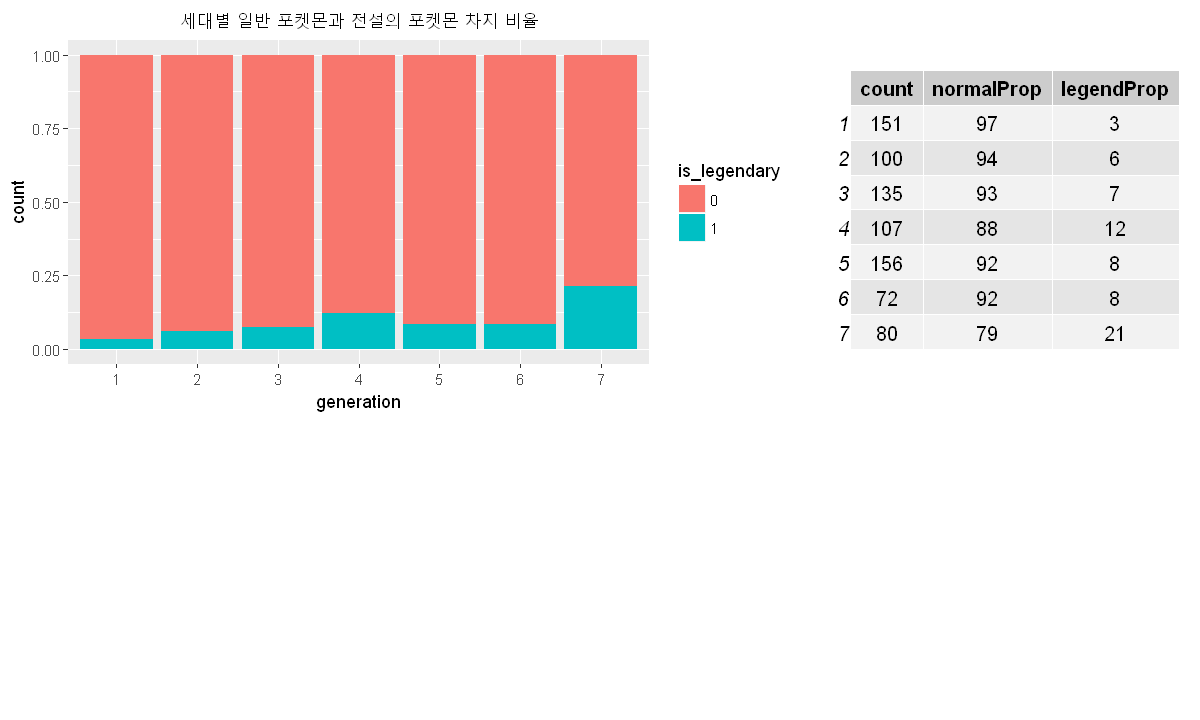

In [7]:
# barplot(fill)
p1_3 <- pokemon %>% 
  ggplot(aes(generation, fill = is_legendary)) +
  geom_bar(position = "fill") +
  ggtitle("세대별 일반 포켓몬과 전설의 포켓몬 차지 비율")+
  theme(plot.title = element_text(hjust = 0.5))

# table
totalDf <- c()
for(i in 1:length(unique(pokemon$generation))){
  temp <- pokemon %>% filter(generation == i)  
  temp <- temp %>% 
    summarise(count = n(),
              normalProp = round(prop.table(table(temp[,"is_legendary"] == 1)),2)[1]*100,
              legendProp = round(prop.table(table(temp[,"is_legendary"] == 1)),2)[2]*100)
  totalDf <- rbind(totalDf, temp)
}
t1_3 <- tableGrob(totalDf)
  
grid.arrange(p1_3, t1_3, ncol = 2, widths = c(6,3), heights = c(7,5))

---

## 2) 포켓몬 타입(type1, type2)
- steel 타입 : 2세대 최초 등장
- fairy 타입 : 5세대 최초 등장

### 2-1) 일반 포켓몬 주(type1), 서브(type2) visualization

### 1. 일반 포켓몬 주 타입 (type1)

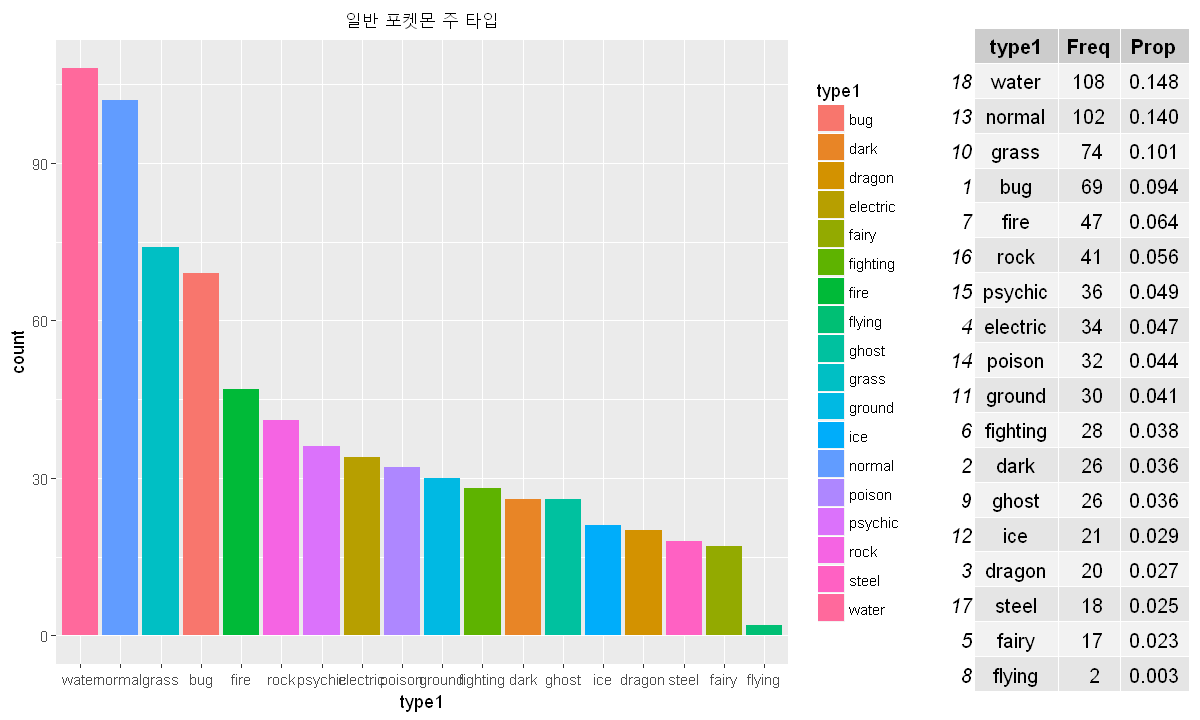

In [8]:
## 그림 크기 조절
options(repr.plot.width=10, repr.plot.height=6)

# 주(type1)
# barplot
p2_1_1 <- normal %>%
  filter(is_legendary == 0) %>% 
  group_by(type1) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(type1, -count), y = count, fill = type1))+
  geom_bar(stat = "identity")+ 
  ggtitle("일반 포켓몬 주 타입")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type1")

# table
df1 <- data.frame(table(normal$type1))
colnames(df1) <- c("type1", "Freq")
df2 <- data.frame(round(prop.table(table(normal$type1)),3))
colnames(df2) <- c("type1", "Prop")
df <- merge(df1, df2, by = "type1")
ndf <- df[order(-df$Freq),]
t2_1_1 <- tableGrob(ndf)

grid.arrange(p2_1_1, t2_1_1, ncol = 2, widths = c(10,3))

### 일반 포켓몬 주 타입 (type1)
- water, normal가 각각 1,2위로 개체수가 가장 많고 그 다음으로 grass, bug가 주 타입인 포켓몬들이 많다.
- 반면에 flying가 주 타입인 포켓몬은 2마리 뿐이다.(음뱃, 음번)

---

### 2. 일반 포켓몬 서브 타입 (type2)

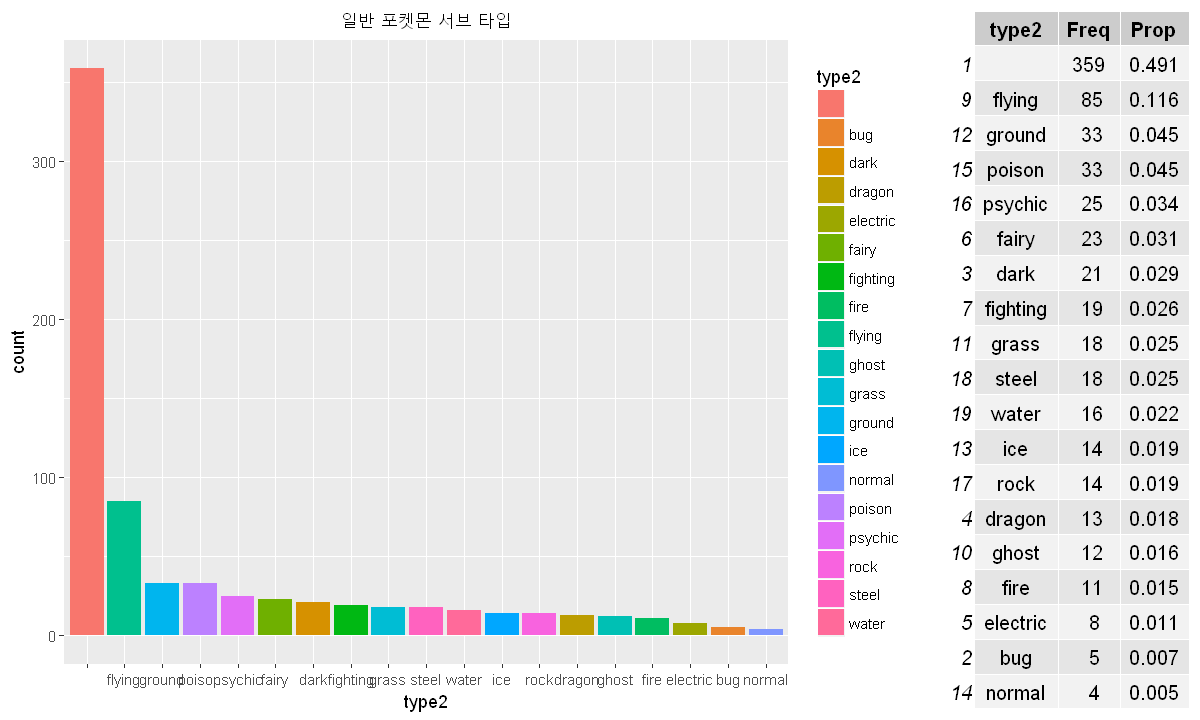

In [9]:
# 서브(type2)
# barplot
p2_1_2 <- normal %>%
  filter(is_legendary == 0) %>% 
  group_by(type2) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(type2, -count), y = count, fill = type2))+
  geom_bar(stat = "identity")+ 
  ggtitle("일반 포켓몬 서브 타입")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type2")

# table
df1 <- data.frame(table(normal$type2))
colnames(df1) <- c("type2", "Freq")
df2 <- data.frame(round(prop.table(table(normal$type2)),3))
colnames(df2) <- c("type2", "Prop")
df <- merge(df1, df2, by = "type2")
ndf <- df[order(-df$Freq),]
t2_1_2 <- tableGrob(ndf)

grid.arrange(p2_1_2, t2_1_2, ncol = 2, widths = c(10,3))

### 일반 포켓몬 서브 타입 (type2)
- 서브 타입이 없는 포켓몬은 약 49%이다.
- 서브 타입을 가지고 있는 포켓몬 중에서는 주 타입(type1)과 반대로 flying 타입이 압도적인 1위를 보여준다.
- ground, poison이 2,3위를 기록하고 있으며, normal이 서브타입인 경우는 가장 적다.

---
### 2-2) 전설의 포켓몬 주(type1), 서브(type2) visualization

### 1. 전설의 포켓몬 주 타입(type1)

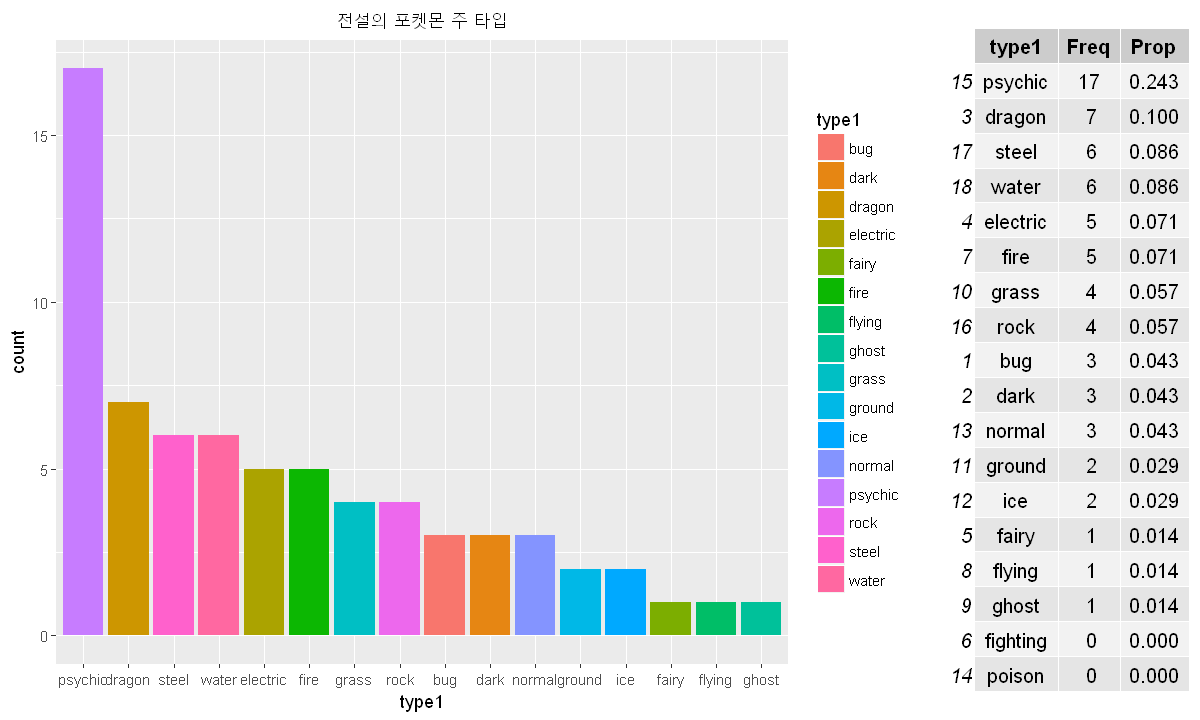

In [10]:
# 주(type1)
# barplot
p2_2_1 <- legend %>% 
  filter(is_legendary == 1) %>% 
  group_by(type1) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(type1, -count), y = count, fill = type1))+
  geom_bar(stat = "identity")+ 
  ggtitle("전설의 포켓몬 주 타입")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type1")

# table
df1 <- data.frame(table(legend$type1))
colnames(df1) <- c("type1", "Freq")
df2 <- data.frame(round(prop.table(table(legend$type1)),3))
colnames(df2) <- c("type1", "Prop")
df <- merge(df1, df2, by = "type1")
ndf <- df[order(-df$Freq),]
t2_2_1 <- tableGrob(ndf)

grid.arrange(p2_2_1, t2_2_1, ncol = 2, widths = c(10,3))

### 전설의 포켓몬 주 타입(type1)
- psychic 타입 포켓몬은 전체의 약 24%를 차지하고 있다.
- 그 외 dragon, steel, water, electric, fire 타입들이 높은 개체수를 보인다.
- fighting, posion가 주 타입인 포켓몬은 존재하지 않는다.
---
### 2. 전설의 포켓몬 서브 타입(type2)

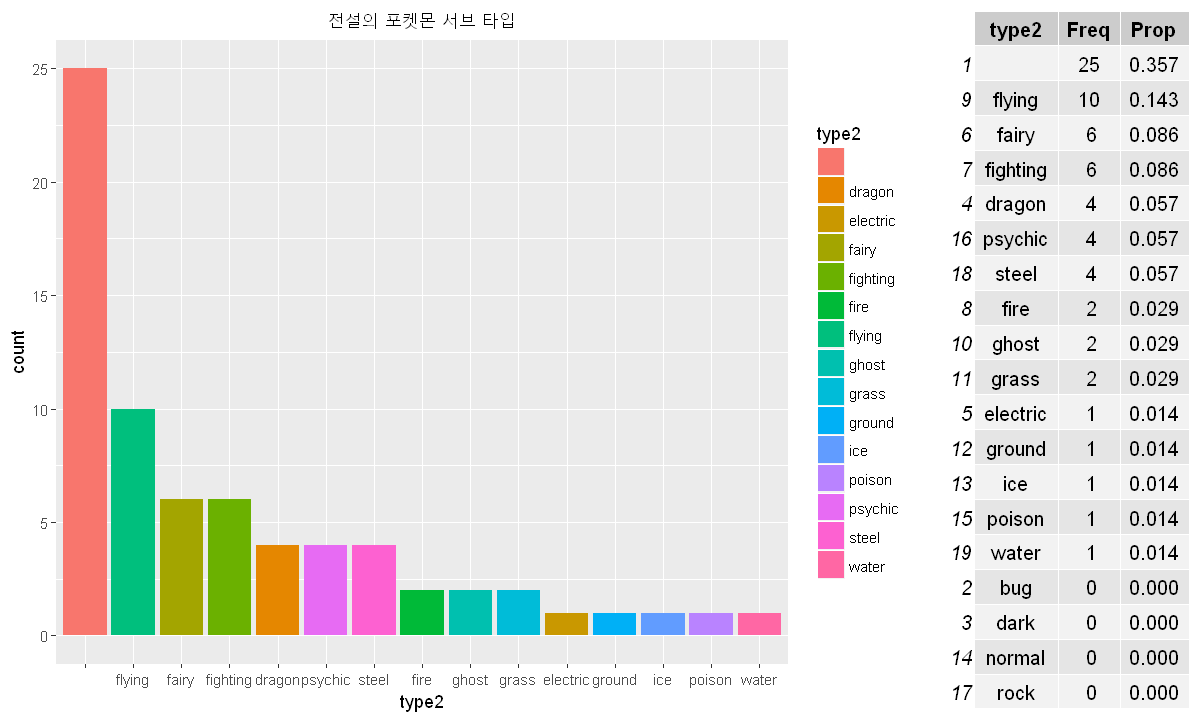

In [11]:
# 서브(type2)
# barplot
p2_2_2 <- legend %>% 
  filter(is_legendary == 1) %>% 
  group_by(type2) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(type2, -count), y = count, fill = type2))+
  geom_bar(stat = "identity")+ 
  ggtitle("전설의 포켓몬 서브 타입")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type2")

# table
df1 <- data.frame(table(legend$type2))
colnames(df1) <- c("type2", "Freq")
df2 <- data.frame(round(prop.table(table(legend$type2)),3))
colnames(df2) <- c("type2", "Prop")
df <- merge(df1, df2, by = "type2")
ndf <- df[order(-df$Freq),]
t2_2_2 <- tableGrob(ndf)

grid.arrange(p2_2_2, t2_2_2, ncol = 2, widths = c(10,3))

### 전설의 포켓몬 서브 타입(type2)
- 일반포켓몬과 동일하게 서브 타입이 없거나 flyting 인 경우가 가장 많다. 그 외 fairy, fighting 타입을 서브 타입으로 가지는 포켓몬이 상위권을 차지한다.
- bug, dark, normal, rock가 서브 타입인 포켓몬은 존재하지 않는다.

---
### 2-3) 포켓몬 전체 타입 (type) = ( 주(type1), 서브(type2) )  visualization

In [12]:
pokemon <- pokemon %>%
  mutate(type = paste(type1, type2, sep = ","))

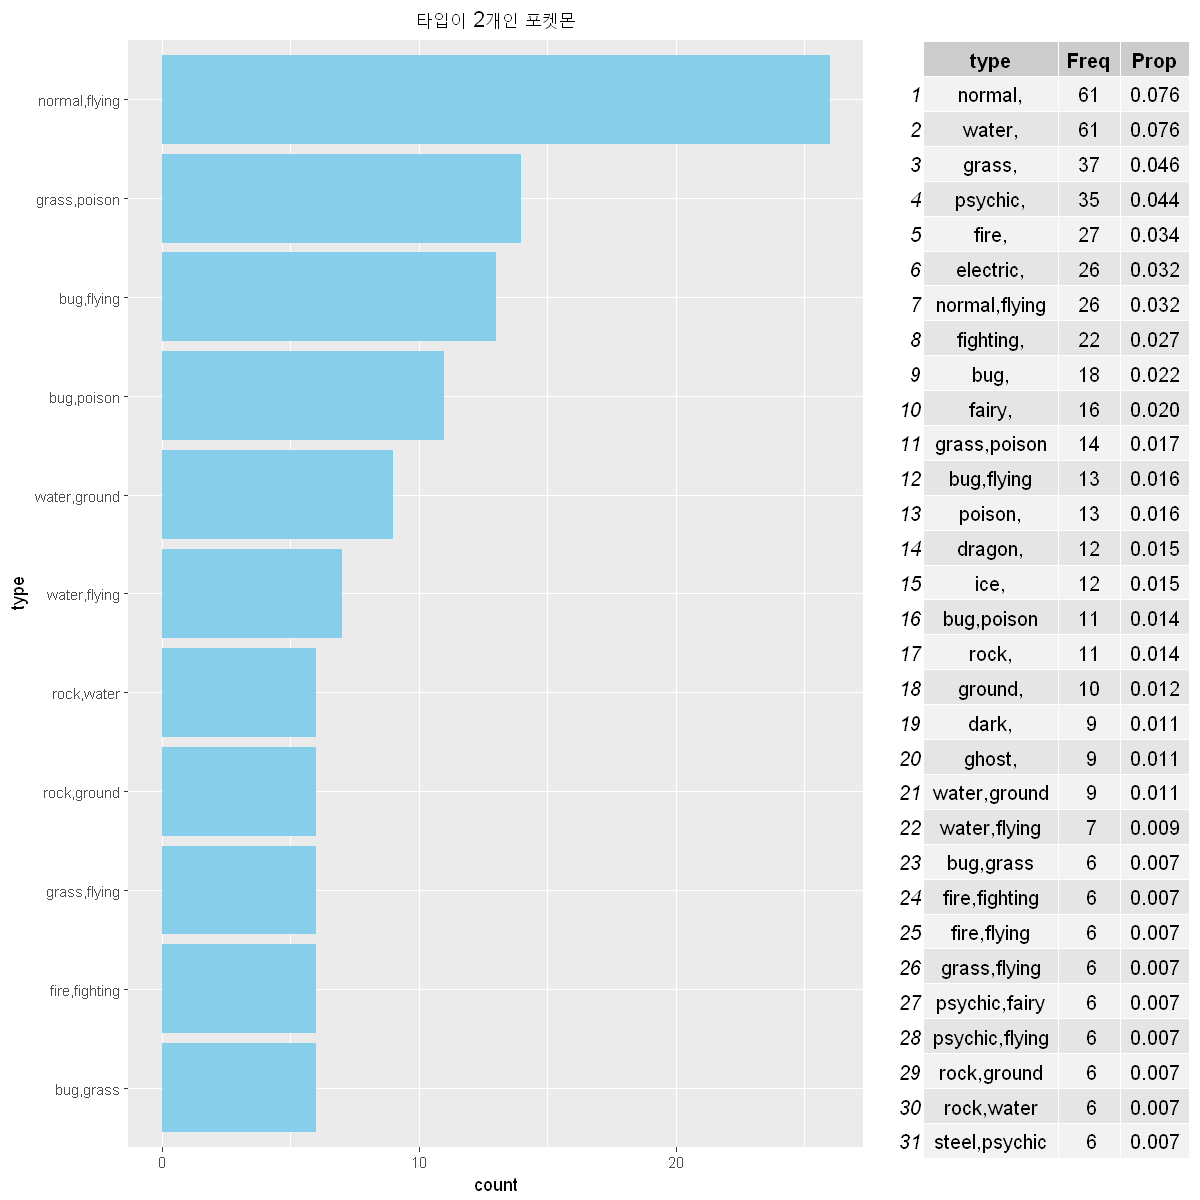

In [13]:
# 그림 크기 조절
options(repr.plot.width=10, repr.plot.height=10)

# barplot
p2_3 <- pokemon %>% 
  filter(is_legendary == 0 & type2 != "") %>% 
  group_by(type) %>% 
  summarise(count = n()) %>% 
  filter(count >= 6) %>% 
  ggplot(aes(x = reorder(type,count), y = count))+
  geom_bar(fill = "skyblue", stat = "identity")+
  coord_flip()+
  ggtitle("타입이 2개인 포켓몬")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type")

# table
df1 <- data.frame(table(pokemon$type))
colnames(df1) <- c("type", "Freq")
df2 <- data.frame(round(prop.table(table(pokemon$type)),3))
colnames(df2) <- c("type", "Prop")
df <- merge(df1, df2, by = "type")
ndf <- df[order(-df$Freq),]
ndf <- ndf %>% 
  filter(Freq >= 6)
t2_3 <- tableGrob(ndf)

grid.arrange(p2_3, t2_3, ncol = 2, widths = c(8,3))

### 22. water, flying(약점이 강화되는 case) : 7마리
- 물 포켓몬들이 비행도 가능하다?
- water/flying 각각 전기에 2배의 데미지를 입는 약점을 보유 => 전기가 약점인 타입 2가지를 모두 가지고 있으, 전기에 4배의 데미지 받음
- 한마리 포켓몬이 water / flying 2가지 타입의 포켓몬에 대해서는 약점이 반감되지만 약점이 강화되거나 늘어남

### 30. rock, water (약점이 보완되는 case) : 6마리
- rock 타입은 water에 4배의 데미지를 입는다. 
- 하지만 서브 타입이 water이기 때문에 1배의 데미지를 받는다.

### 주 타입, 서브 타입 조합에 따라 약점이 강화되거나 보완되기도 함

---
### 2-4) 타입이 2개인 전설의 포켓몬 

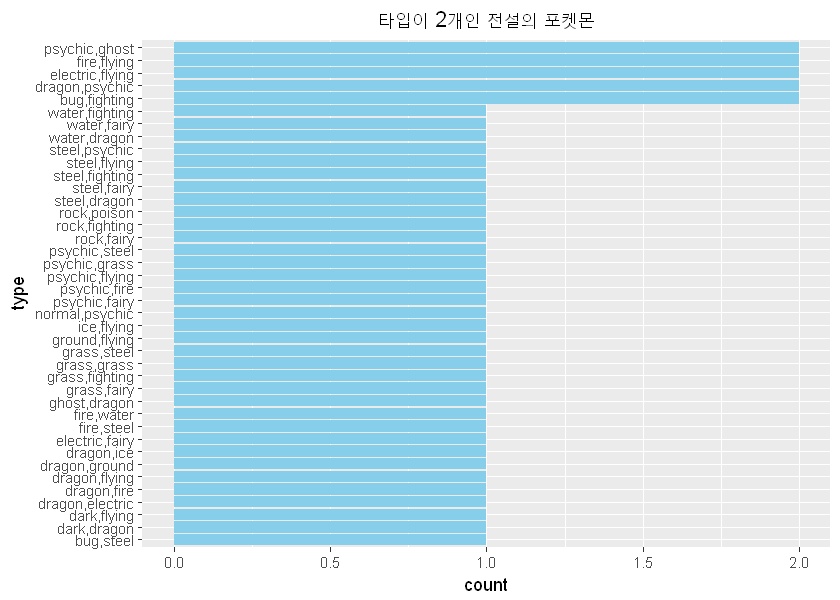

In [14]:
# 그림 크기 조절
options(repr.plot.width=7, repr.plot.height=5)

# barplot
p2_4 <- pokemon %>% 
  filter(is_legendary == 1 & type2 != "") %>% 
  group_by(type) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(type,count), y = count))+
  geom_bar(fill = "skyblue", stat = "identity")+
  coord_flip()+
  ggtitle("타입이 2개인 전설의 포켓몬")+
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("type")

grid.arrange(p2_4, widths = c(2), heights = c(4))

### 전설의 포켓몬은 주 타입과 서브타입이 고루 섞여있음

---
## 3) 포켓몬 분류(classification)

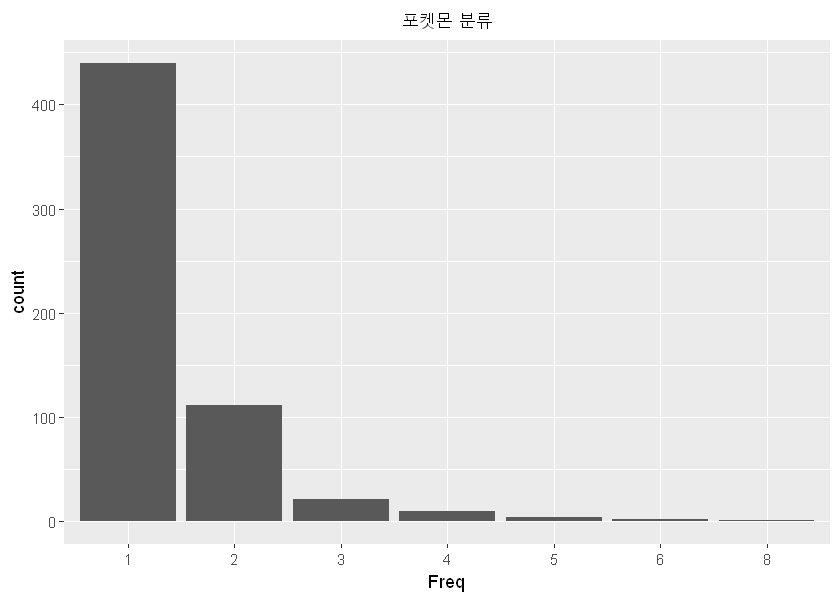

In [15]:
# classfication별로 누적치 확인
class <- as.data.frame(table(pokemon$classfication))
class <- class %>% arrange(-Freq)
class$Freq <- as.factor(class$Freq)

class %>% 
  ggplot(aes(Freq))+
  geom_bar()+ 
  ggtitle("포켓몬 분류")+
  theme(plot.title = element_text(hjust = 0.5))

- 중복되는 classfication 개체수가 적다.
- 1(unique)한 값이 대부분이고 초창기 세대에 만들어진 포켓몬들이 6,8을 차지
### 새로운 포켓몬이 나올때마다 컨셉에 맞춘 ooo 포켓몬 명칭 생성된다.

---
## 4) 능력치(ability)

### 4-1) 일반 포켓몬 세대별 능력치 값 
### 1. visualization

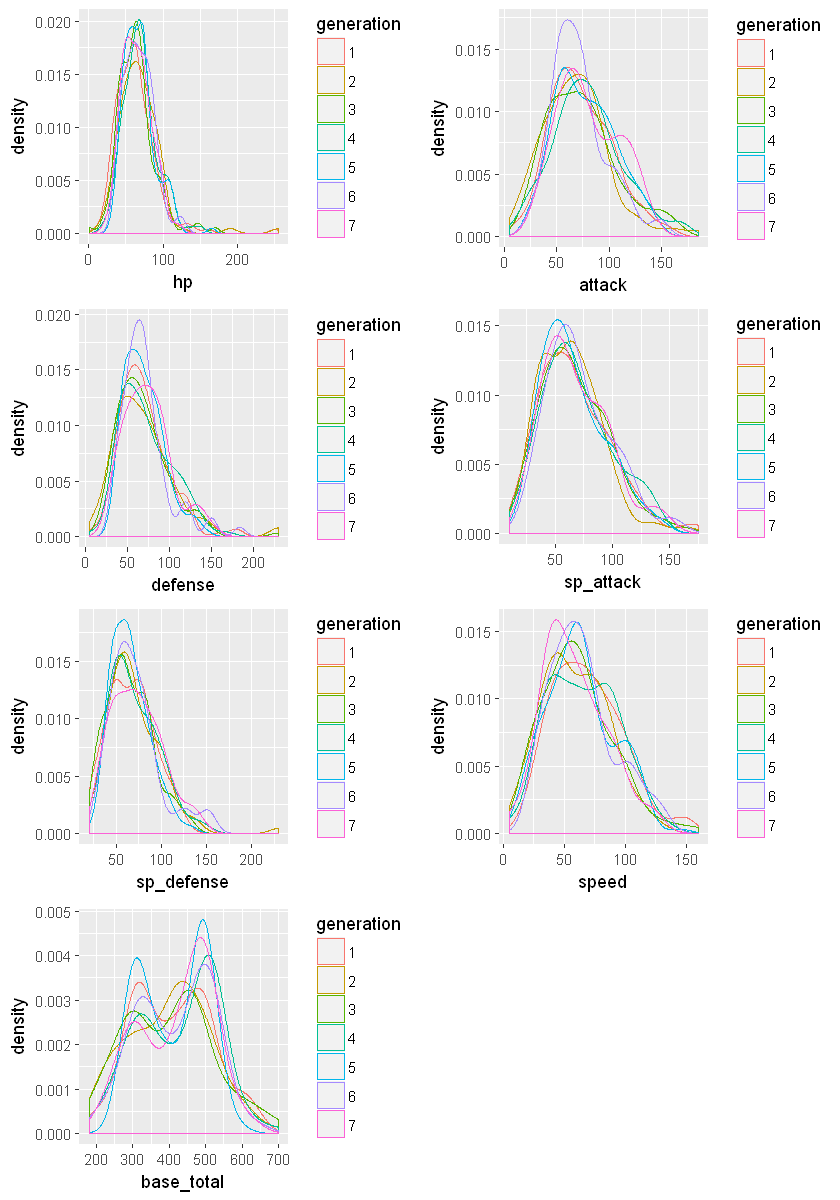

In [16]:
# 그림 크기 조절
options(repr.plot.width=7, repr.plot.height=10)

p4_1_1 <- qplot(hp, data = normal, geom = "density", colour = generation)
p4_1_2 <- qplot(attack, data = normal, geom = "density", colour = generation)
p4_1_3 <- qplot(defense, data = normal, geom = "density", colour = generation)
p4_1_4 <- qplot(sp_attack, data = normal, geom = "density", colour = generation)
p4_1_5 <- qplot(sp_defense, data = normal, geom = "density", colour = generation)
p4_1_6 <- qplot(speed, data = normal, geom = "density", colour = generation)
p4_1_7 <- qplot(base_total, data = normal, geom = "density", colour = generation)
grid.arrange(p4_1_1, p4_1_2, p4_1_3, p4_1_4, p4_1_5, p4_1_6, p4_1_7, ncol = 2)

### 일반 포켓몬 세대별 능력치 비교
- 그래프로 봤을 때 attack, defense를 제외하고 별다른 차이가 보이지 않는다. 
- 통계분석 anova를 통해 각 세대별 능력치의 '다름'이 존재하는지 확인

---
### 2. 통계분석 : anova

In [17]:
# hp
hpResult <- aov(hp ~ generation, data = normal)
summary(hpResult)
# attack
attackResult <- aov(attack ~ generation, data = normal)
summary(attackResult)
# defense
defenseResult <- aov(defense ~ generation, data = normal)
summary(defenseResult)
# sp_attack
sp_attackResult <- aov(sp_attack ~ generation, data = normal)
summary(sp_attackResult)
# sp_defense
sp_defenseResult <- aov(sp_defense ~ generation, data = normal)
summary(sp_defenseResult)
# speed
speedResult <- aov(speed ~ generation, data = normal)
summary(speedResult)
# base_total
base_totalResult <- aov(base_total ~ generation, data = normal)
summary(base_totalResult)

             Df Sum Sq Mean Sq F value Pr(>F)
generation    6   4371   728.4   1.186  0.312
Residuals   724 444764   614.3               

             Df Sum Sq Mean Sq F value Pr(>F)  
generation    6  10105  1684.2   1.813 0.0938 .
Residuals   724 672403   928.7                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

             Df Sum Sq Mean Sq F value Pr(>F)
generation    6   1985   330.8   0.367    0.9
Residuals   724 651946   900.5               

             Df Sum Sq Mean Sq F value Pr(>F)
generation    6   3176   529.4   0.624  0.711
Residuals   724 614343   848.5               

             Df Sum Sq Mean Sq F value Pr(>F)
generation    6   5774   962.4   1.433  0.199
Residuals   724 486118   671.4               

             Df Sum Sq Mean Sq F value Pr(>F)  
generation    6   9030  1505.0   1.972 0.0673 .
Residuals   724 552567   763.2                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

             Df  Sum Sq Mean Sq F value Pr(>F)
generation    6   54748    9125   0.809  0.563
Residuals   724 8162882   11275               

1. hp : p-value가 0.312 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 hp 차이가 없다.
1. attack : p-value가 0.094 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 attack에 차이가 없다.
1. defense : p-value가 0.900 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 defense 차이가 없다.
1. sp_attack : p-value가 0.711 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 sp_attack 차이가 없다.
1. sp_defense : p-value가 0.199 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 sp_defense 차이가 없다.
1. speed : p-value가 0.067 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 speed 차이가 없다.
1. base_total : p-value가 0.563 이므로 유의수준 5%에서 통계적으로 봤을 때 세대별로 base_total 차이가 없다.

### 결론) 일반 포켓몬에서는 세대별 능력치 차이가 존재하지 않는다. 

---
### 4-3) 전설의 포켓몬 세대별 능력치 확인

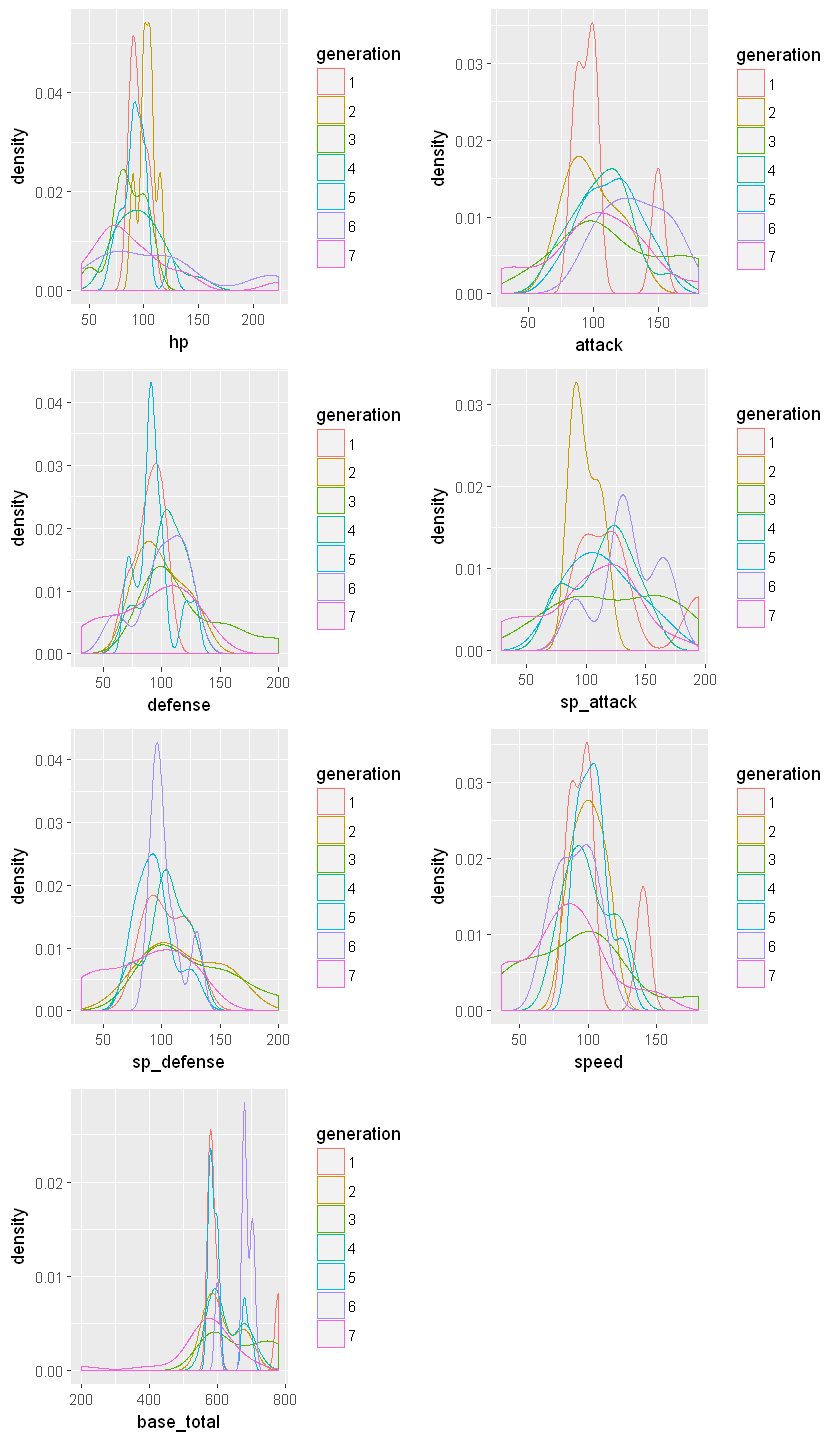

In [18]:
# 그림 크기 조절
options(repr.plot.width=7, repr.plot.height=12)

p4_3_1 <- qplot(hp, data = legend, geom = "density", colour = generation)
p4_3_2 <- qplot(attack, data = legend, geom = "density", colour = generation)
p4_3_3 <- qplot(defense, data = legend, geom = "density", colour = generation)
p4_3_4 <- qplot(sp_attack, data = legend, geom = "density", colour = generation)
p4_3_5 <- qplot(sp_defense, data = legend, geom = "density", colour = generation)
p4_3_6 <- qplot(speed, data = legend, geom = "density", colour = generation)
p4_3_7 <- qplot(base_total, data = legend, geom = "density", colour = generation)
grid.arrange(p4_3_1, p4_3_2, p4_3_3, p4_3_4, p4_3_5, p4_3_6, p4_3_7, ncol = 2)

### 전설의 포켓몬 : 세대별로 전설의 포켓몬은 능력치에서 뚜렷한 차이를 보인다.
### 각각의 그래프에 대한 해석

In [19]:
# 그림 크기 조절
options(repr.plot.width=6, repr.plot.height=3)

### 1. hp

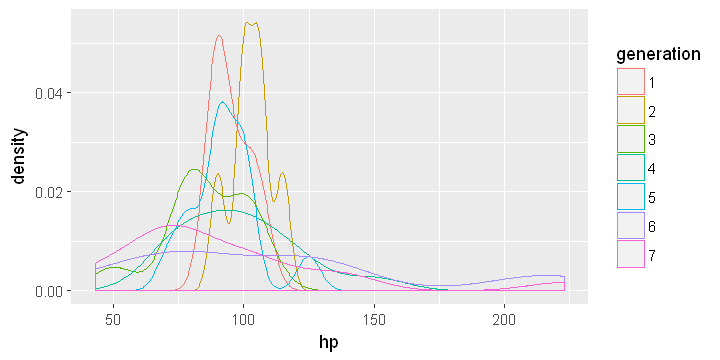

In [20]:
p4_3_1

### hp(전설의 포켓몬)
- 1,2세대 포켓몬은 각각 hp80, 100 주위에 밀집된 분포를 보인다.
- 개체수가 적은 6,7세대 포켓몬은 전체적으로 고른 분포를 보이며 hp능력치가 200이 넘어가는 포켓몬도 존재한다.
---
### 2. attack

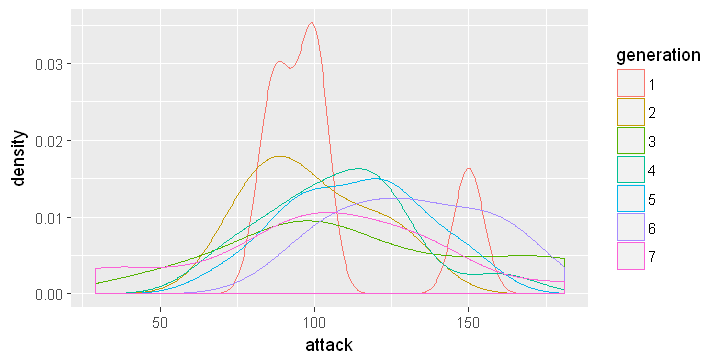

In [21]:
p4_3_2

### attack(전설의 포켓몬)
- 1세대 포켓몬이 attack 80, 150 주위에 밀집된 분포를 보인다.
- attack 150이상인 포켓몬은  4세대가 가장 많다.
---
### 3. defense

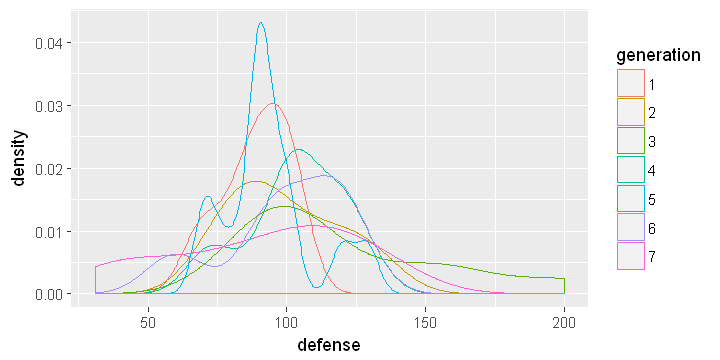

In [22]:
p4_3_3

### defense(전설의 포켓몬)
- 5세대 포켓몬이 defense 80 주위에 밀집된 분포를 보인다.
- defense가 가장 높은 포켓몬은 4세대에 전부 존재한다.
---
### 4. sp_attack

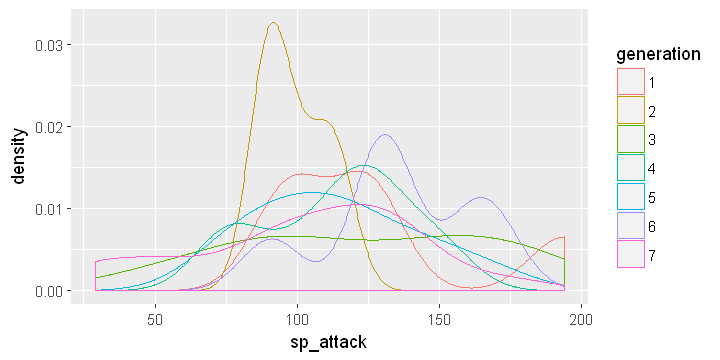

In [23]:
p4_3_4

### sp_attack(전설의 포켓몬)
- 2세대 포켓몬이 sp_attack 80 주위에 밀집된 분포를 보인다.
- sp_attack이 가장 높은 포켓몬은 1세대에 가장 많고 그 다음으로는 3세대 포켓몬이다.
---
### 5. sp_defense

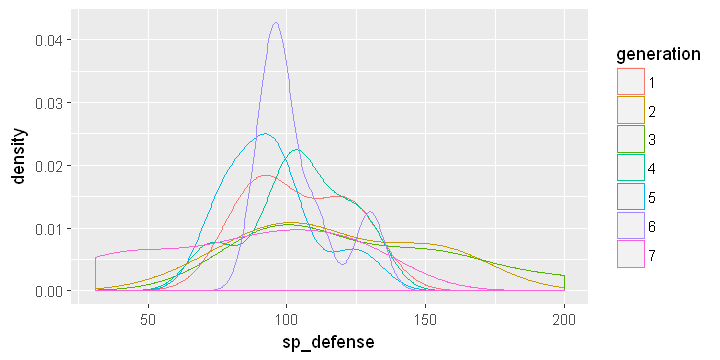

In [24]:
p4_3_5

### sp_defense(전설의 포켓몬)
- 6세대 포켓몬이 sp_defense 90 주위에 가장 밀집된 분포를 보인다.
- sp_defense가 가장 높은 포켓몬은 3세대에 가장 많고 그 다음으로는 2세대에 존재한다.
---
### 6. speed

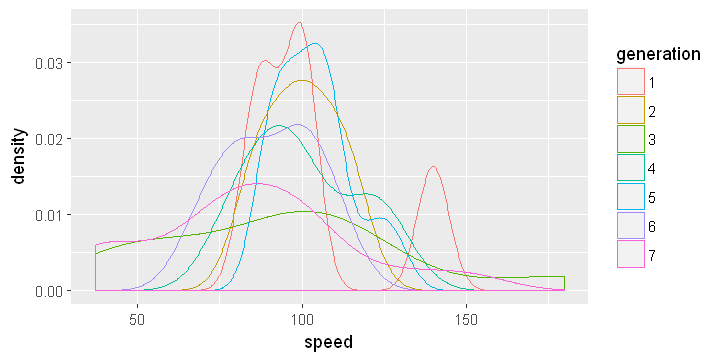

In [25]:
# speed
p4_3_6

### speed(전설의 포켓몬)
- attack과 비슷하게 1세대 포켓몬이 speed 100, 130 주위에 밀집된 분포를 보인다.
- speed가 가장 빠른 포켓몬은 3세대 포켓몬이다.
---
### 7. base_total

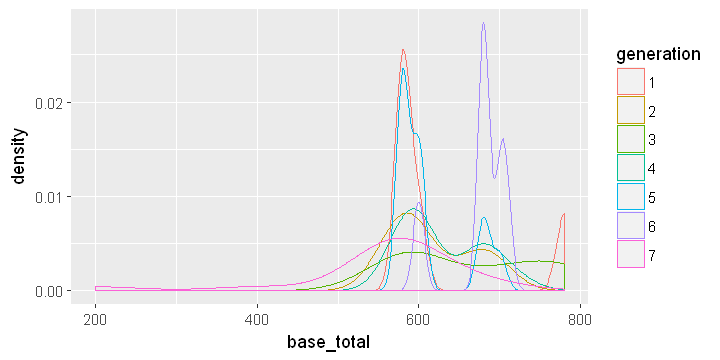

In [26]:
# base_total
p4_3_7

### base_total(전설의 포켓몬)
- total 능력치가 가장 높은 포켓몬은 대부분 1세대 포켓몬이다.
- 6세대는 다른 세대에 비해 높은 능력치를 보유한 포켓몬이 많다.

---
###  4-4) 일반 포켓몬 타입별로 능력치 확인 : boxplot 

In [1]:
# 그림 크기 조절
options(repr.plot.width=10, repr.plot.height=6)

### 1. hp

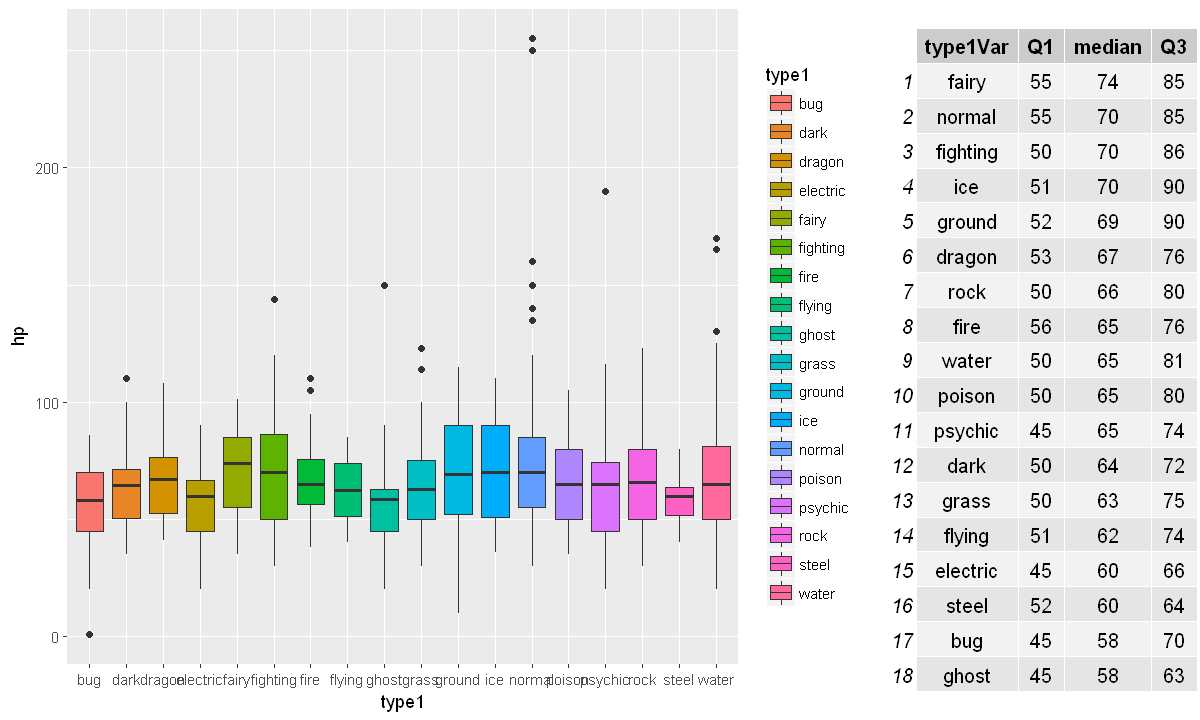

In [28]:
# barplot
p4_4_1 <- normal %>% 
  ggplot(aes(type1, hp)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(hp)[2],0),
              median = round(quantile(hp)[3],0),
              Q3 = round(quantile(hp)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_1 <- tableGrob(ndf)

grid.arrange(p4_4_1, t4_4_1, ncol = 2, widths = c(8,3))

### hp(일반 포켓몬)  
- fairy 타입 포켓몬의 hp 중앙값이 가장 높다. 그 다음으로 normal, fighting, ice가 높은 순위를 보인다.
- normal 타입 포켓몬은 hp가 특별히 높은 포켓몬이 존재한다.(outlier)
- ghost, bug 타입 포켓몬 대부분이 hp가 낮다.

---
### 2. attack

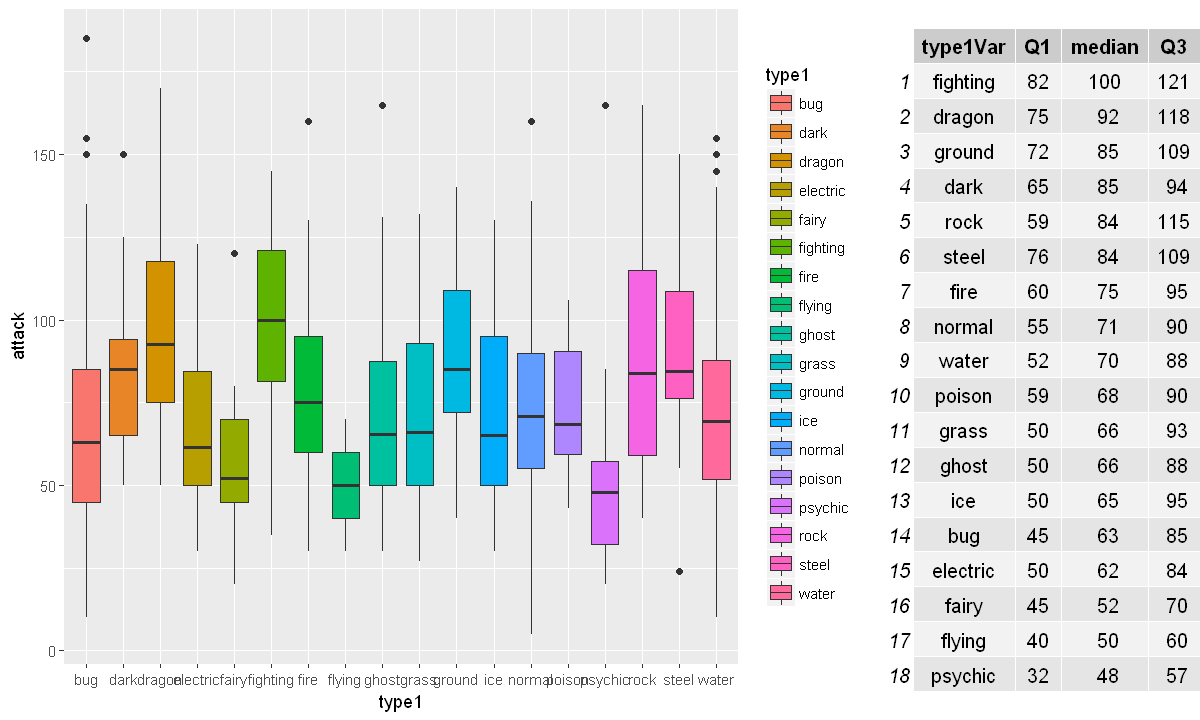

In [29]:
# barplot
p4_4_2 <- normal %>% 
  ggplot(aes(type1, attack)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(attack)[2],0),
              median = round(quantile(attack)[3],0),
              Q3 = round(quantile(attack)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_2 <- tableGrob(ndf)

grid.arrange(p4_4_2, t4_4_2, ncol = 2, widths = c(8,3))

### attack(일반 포켓몬) - 육체적 피지컬로 승부
- fighting 타입이 1위로 높은 attack 능력치를 보여준다. 그 다음으로 dragon타입이 높은 attack 능력치 보유.
- psychic, flying, fairy 타입 포켓몬은 물리적인 attack 능력치가 낮다. (머리로 승부하는 포켓몬)
---
### 3. defense

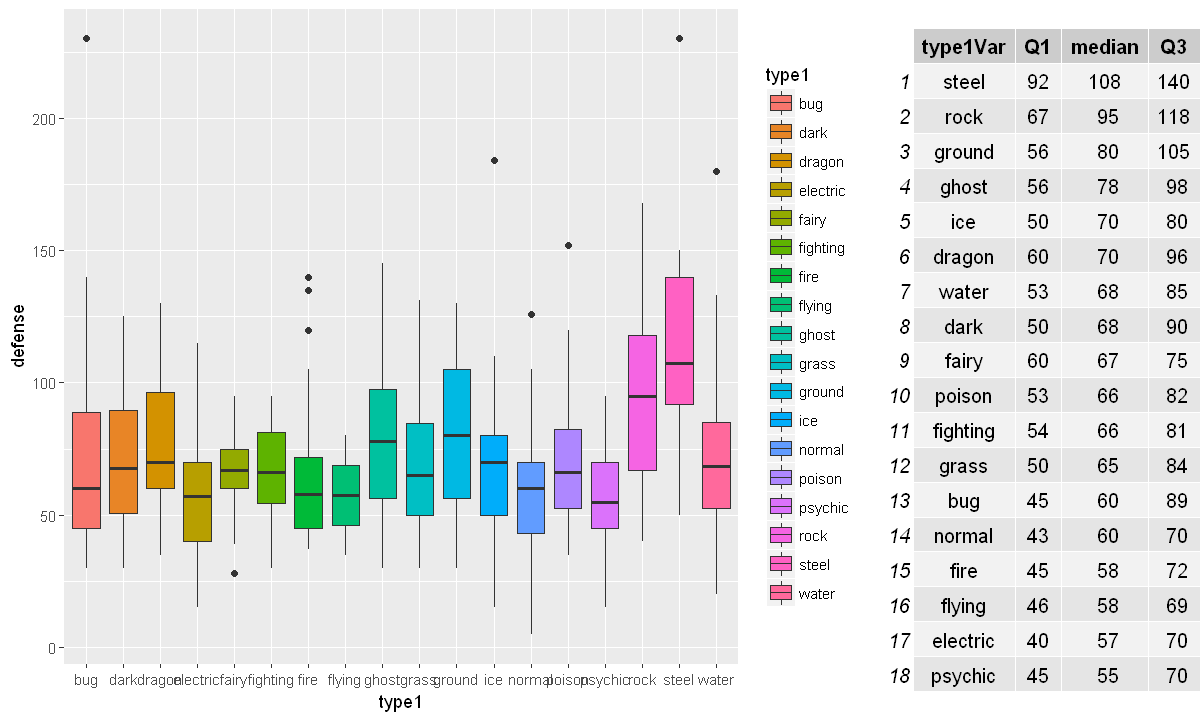

In [30]:
# barplot
p4_4_3 <- normal %>% 
  ggplot(aes(type1, defense)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(defense)[2],0),
              median = round(quantile(defense)[3],0),
              Q3 = round(quantile(defense)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_3 <- tableGrob(ndf)

grid.arrange(p4_4_3, t4_4_3, ncol = 2, widths = c(8,3))

### defense(일반 포켓몬) - 바위처럼 단단하게
- steel 타입 포켓몬이 1위, rock 타입 포켓몬 2위의 defense를 보유하고 있다.
- hp가 높은 fairy, fighting 포켓몬은 중간 정도의 능력치를 보유하고 있다.
- bug 타입 포켓몬 outlier : 단단지(다른 bug 포켓몬에 비해 방어와 관련된 능력치가 높은 값을 보유)
- psychic, electric, flying, fire 타입 포켓몬은 상대적으로 defense가 낮기 때문에 물리적인 공격(attack)에 취약하다.
---
### 4. sp_attack

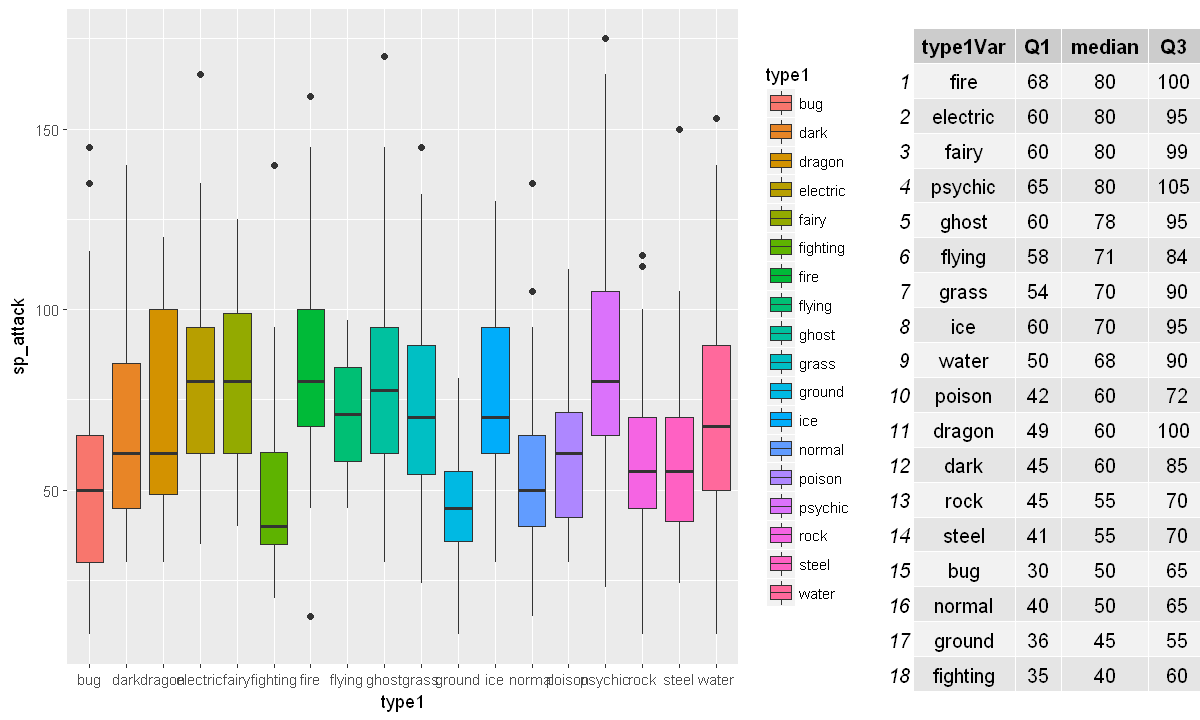

In [31]:
# barplot
p4_4_4 <- normal %>% 
  ggplot(aes(type1, sp_attack)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(sp_attack)[2],0),
              median = round(quantile(sp_attack)[3],0),
              Q3 = round(quantile(sp_attack)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_4 <- tableGrob(ndf)

grid.arrange(p4_4_4, t4_4_4, ncol = 2, widths = c(8,3))

### sp_attack(일반 포켓몬)
- attack이 하위권인 포켓몬들이 상위권이 오름
- psychic ,fairy 타입 포켓몬과 예상외로 electric, fire 타입 포켓몬들이 높은 sp_attack 능력치를 보유
- fighting은 중위수가 최하위를 기록(무식하면 힘만 세다.)
---
### 5. sp_defense

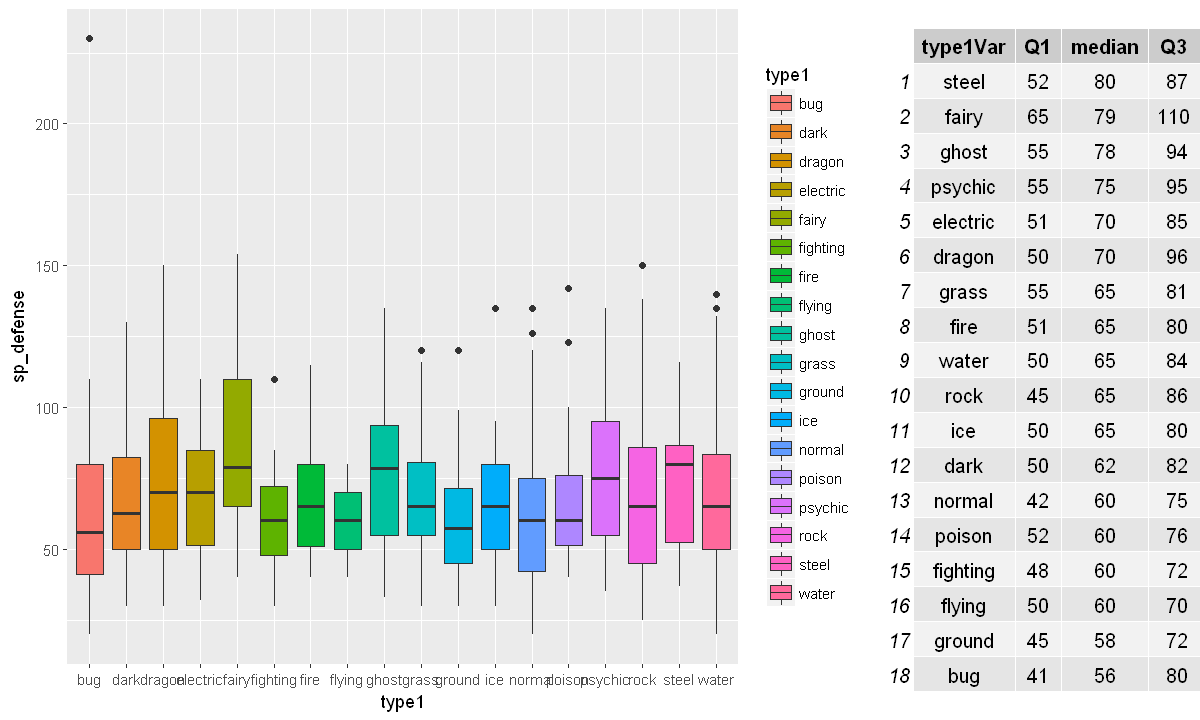

In [32]:
# barplot
p4_4_5 <- normal %>% 
  ggplot(aes(type1, sp_defense)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(sp_defense)[2],0),
              median = round(quantile(sp_defense)[3],0),
              Q3 = round(quantile(sp_defense)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_5 <- tableGrob(ndf)

grid.arrange(p4_4_5, t4_4_5, ncol = 2, widths = c(8,3))

### sp_defense(일반 포켓몬)
- steel 타입은 defense와 더불어 sp_defense에서도 높은 능력치를 보유하고 있다.
- 그 외 fairy, ghost, psychic 타입 포켓몬이 높은 sp_defense 보유
- 물리적인 공격 attack에서 최상위권에 머물돈 fighting 타입 포켓몬은 여전히 하위권을 기록
- bug포켓몬은 대체로 sp_defense가 낮지만 단단지(outlier)는 defense와 더불어 sp_defense도 높다. => 방어력만 높고 공격력은 최하위권에 머물러있는 포켓몬
---
### 6. speed

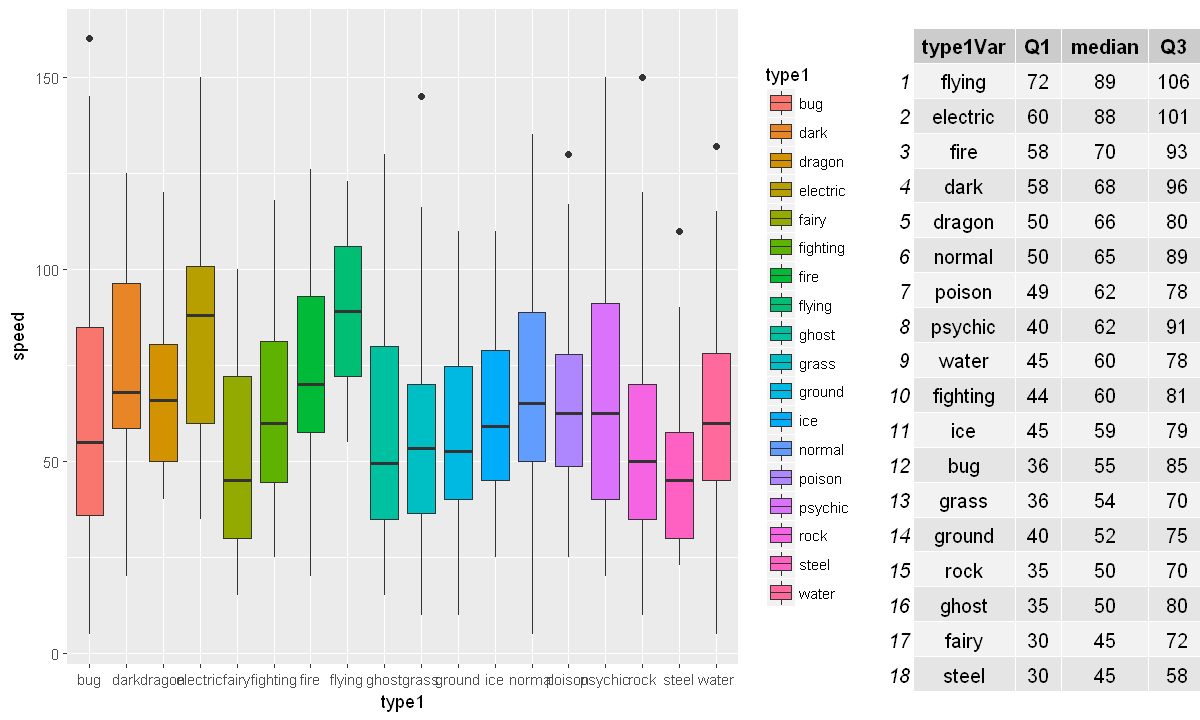

In [33]:
# barplot
p4_4_6 <- normal %>% 
  ggplot(aes(type1, speed)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(speed)[2],0),
              median = round(quantile(speed)[3],0),
              Q3 = round(quantile(speed)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_6 <- tableGrob(ndf)

grid.arrange(p4_4_6, t4_4_6, ncol = 2, widths = c(8,3))

### speed (일반 포켓몬)
- flying 타입이 1위, electric 타입이 2위로 다른 능력치에 비해 높은 speed를 보유하고 있다.
- 특수 계열 능력치에서 높은 순위를 보이던 fairy 타입이 최하위권을 기록
- 방어 계열 능력치에서 높은 순위를 보이던 steel 타입이 최하위권을 기록
- bug 타입 outlier로 나타난 포켓몬은 '아이스크'로서 서브타입으로 flying을 보유하고 있기 때문에 높은 speed를 보유하고 있다.
---
### 7. base_total

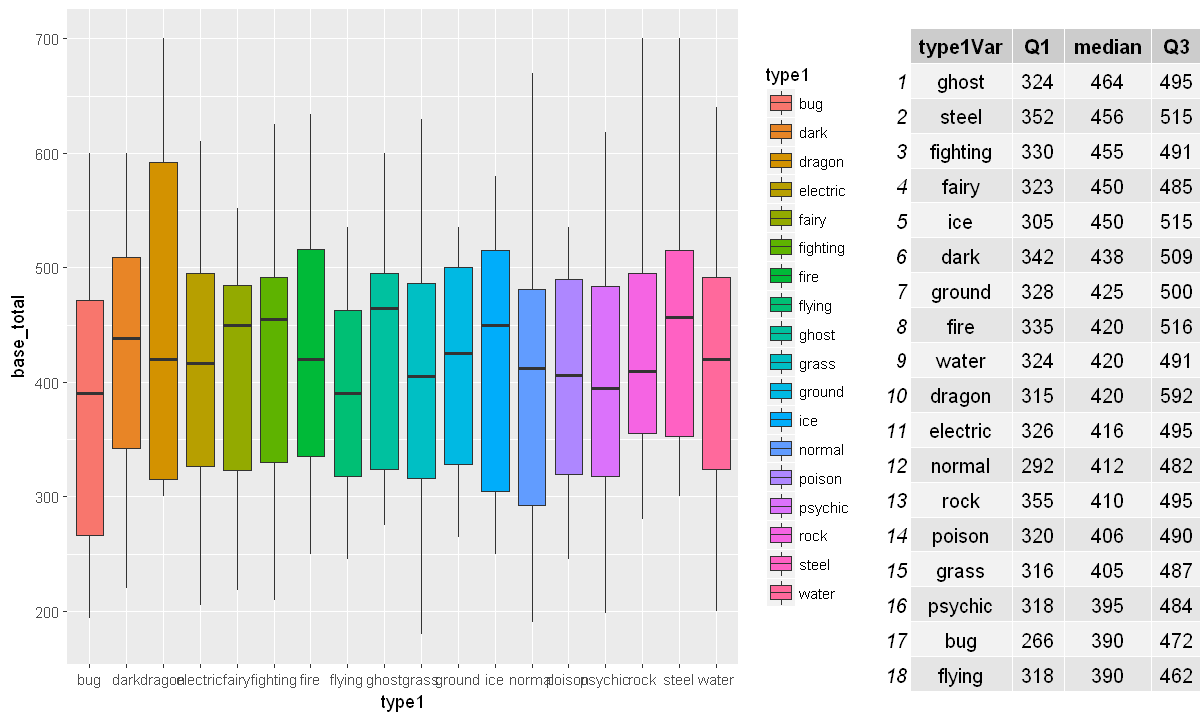

In [34]:
# barplot
p4_4_7 <- normal %>% 
  ggplot(aes(type1, base_total)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(normal[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- normal %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(Q1 = round(quantile(base_total)[2],0),
              median = round(quantile(base_total)[3],0),
              Q3 = round(quantile(base_total)[4],0))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:18
t4_4_7 <- tableGrob(ndf)

grid.arrange(p4_4_7, t4_4_7, ncol = 2, widths = c(8,3))

### base_total (일반 포켓몬)
- ghost 타입 포켓몬이 total 능력치가 좋은편
- dragon 타입 포켓몬은 중위수 절대 편차가 높은 편이다. => 최종 진화 형태의 dragon 타입 포켓몬은 다른 포켓몬이 비해 우수한 능력치 보유

---
###  4-5) 전설의 포켓몬 타입별로 능력치 확인 : boxplot 

In [35]:
# 그림 크기 조절
options(repr.plot.width=10, repr.plot.height=5)

### 1. hp

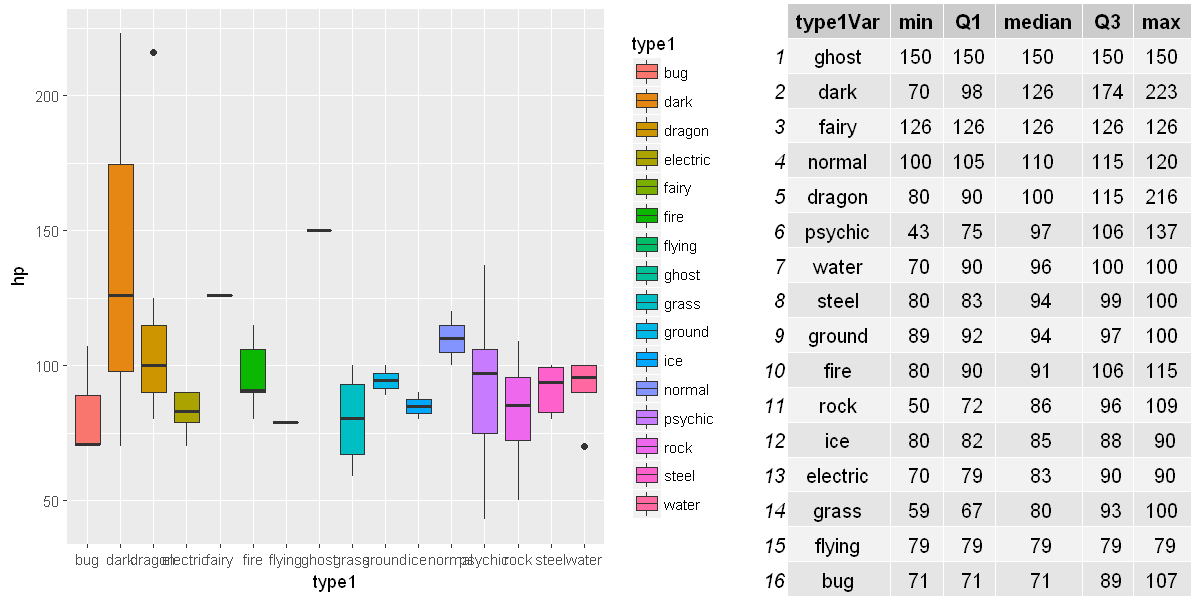

In [36]:
# barplot
p4_5_1 <- legend %>% 
  ggplot(aes(type1, hp)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(hp),
              Q1 = round(quantile(hp)[2],0),
              median = round(quantile(hp)[3],0),
              Q3 = round(quantile(hp)[4],0),
              max = max(hp))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_1 <- tableGrob(ndf)

grid.arrange(p4_5_1, t4_5_1, ncol = 2, widths = c(8,5))

### hp(전설의 포켓몬)
- 중위수를 기준으로 ghost 포켓몬(개체수 1)이 가장 높고, bug 포켓몬(개체수 3)이 가장 낮다. 
- [dark, dragon] 타입을 보유하고 있는 '약식킹'이 가장 높은 hp(223)를 보유하고 있다.
- [dragon, ground] 타입을 보유하고 있는 '지가르데'가 다음으로 높은 hp(216)를 보유하고 있다.
- hp가 가장 낮은 포켓몬 2마리는 psychic 타입의 포켓몬이다.
---
### 2. attack

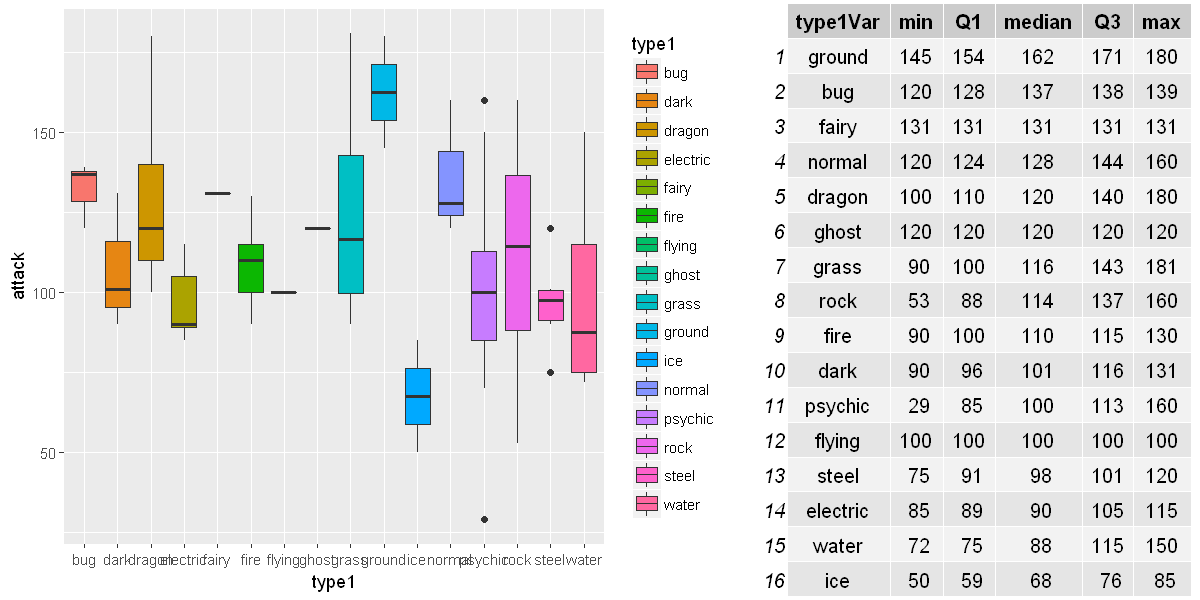

In [37]:
# barplot
p4_5_2 <- legend %>% 
  ggplot(aes(type1, attack)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(attack),
              Q1 = round(quantile(attack)[2],0),
              median = round(quantile(attack)[3],0),
              Q3 = round(quantile(attack)[4],0),
              max = max(attack))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_2 <- tableGrob(ndf)

grid.arrange(p4_5_2, t4_5_2, ncol = 2, widths = c(8,5))

### attack(전설의 포켓몬)
- 중위수를 기준으로 ground 포켓몬(개체수 2)이 가장 높고, bug 포켓몬(개체수 2)이 가장 낮다. 
- [grass, steel] 타입을 보유하고 있는 '종이신도'가 가장 높은 attack(181)을 보유하고 있다. 하지만 hp는 59로 상당히 낮은편이다.
- [dragon, flying] 타입을 보유하고 있는 '레쿠쟈'와 ground 타입을 보유한 '그란돈'이 다음으로 높은 attack(180)를 보유하고 있다.
- attack가 가장 낮은 포켓몬 2마리는 psychic 타입의 포켓몬이다.
---
### 3. defense

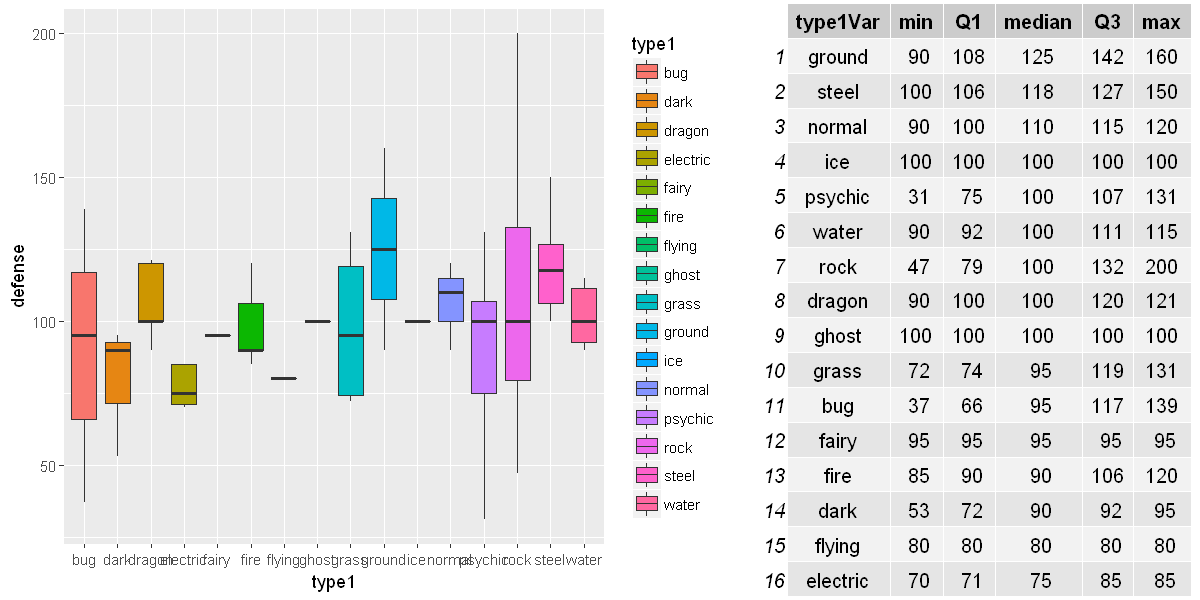

In [38]:
# barplot
p4_5_3 <- legend %>% 
  ggplot(aes(type1, defense)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(defense),
              Q1 = round(quantile(defense)[2],0),
              median = round(quantile(defense)[3],0),
              Q3 = round(quantile(defense)[4],0),
              max = max(defense))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_3 <- tableGrob(ndf)

grid.arrange(p4_5_3, t4_5_3, ncol = 2, widths = c(8,5))

### defense(전설의 포켓몬)
- attack과 동일하게 중위수를 기준으로 ground 포켓몬(개체수 2)이 가장 높은 능력치를 보여준다.
- electric, flying 타입의 포켓몬은 낮은 편에 속한다.
- rock 타입을 보유하고 있는 '레지락'이 가장 높은 defense(160)을 보유하고 있다. 
- ground 타입을 보유하고 있는 '그란돈'이 높은 attack과 더불어 defense(160)의 능력치를 보유하고 있다.
- defense가 가장 낮은 포켓몬 2마리는 psychic 타입의 포켓몬이다.
---
### 4. sp_attack

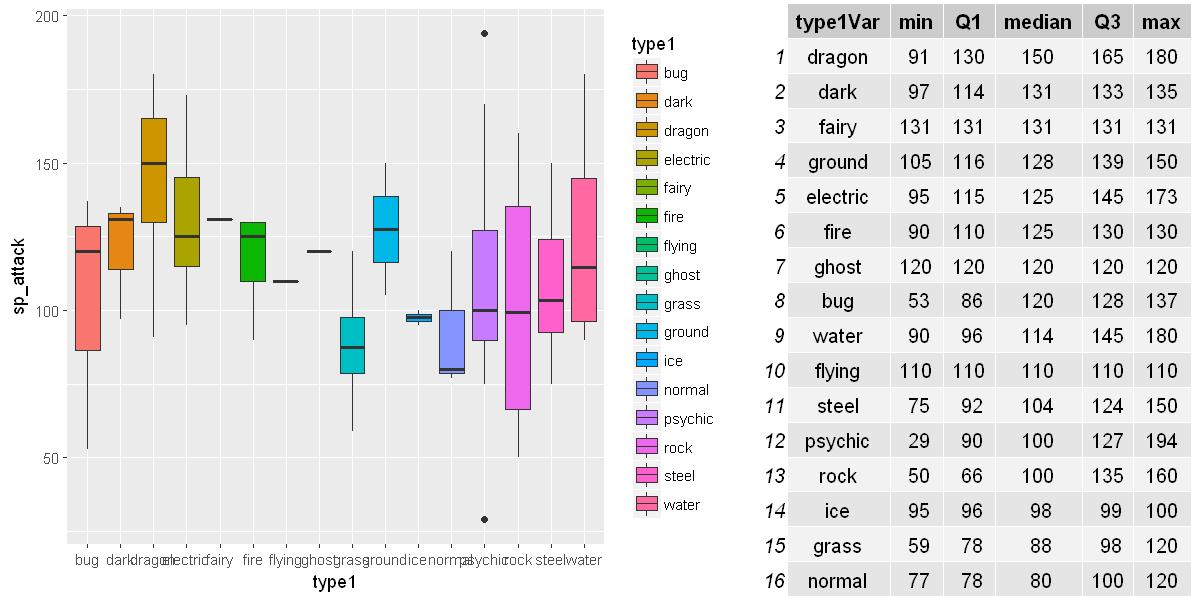

In [39]:
# barplot
p4_5_4 <- legend %>% 
  ggplot(aes(type1, sp_attack)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(sp_attack),
              Q1 = round(quantile(sp_attack)[2],0),
              median = round(quantile(sp_attack)[3],0),
              Q3 = round(quantile(sp_attack)[4],0),
              max = max(sp_attack))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_4 <- tableGrob(ndf)

grid.arrange(p4_5_4, t4_5_4, ncol = 2, widths = c(8,5))

### sp_attack(전설의 포켓몬)
- 중위수를 기준으로 dragon 타입의 포켓몬(개체수 7)이 높은, normal 타입의 포켓몬(개체수 3)은 낮은 sp_attack을 보유하고 있다.
- psychic 타입을 보유하고 있는 '뮤츠'가 가장 높은 sp_attack(194)을 보유하고 있다. 
- [dragon, flying] 타입을 보유하고 있는 '레쿠쟈'가 attack과 더불어 sp_attack(160)에서 높은 능력치를 보유하고 있다.
- sp_attack이 가장 낮은 포켓몬도 psychic 타입의 포켓몬이다.
---
### 5. sp_defense

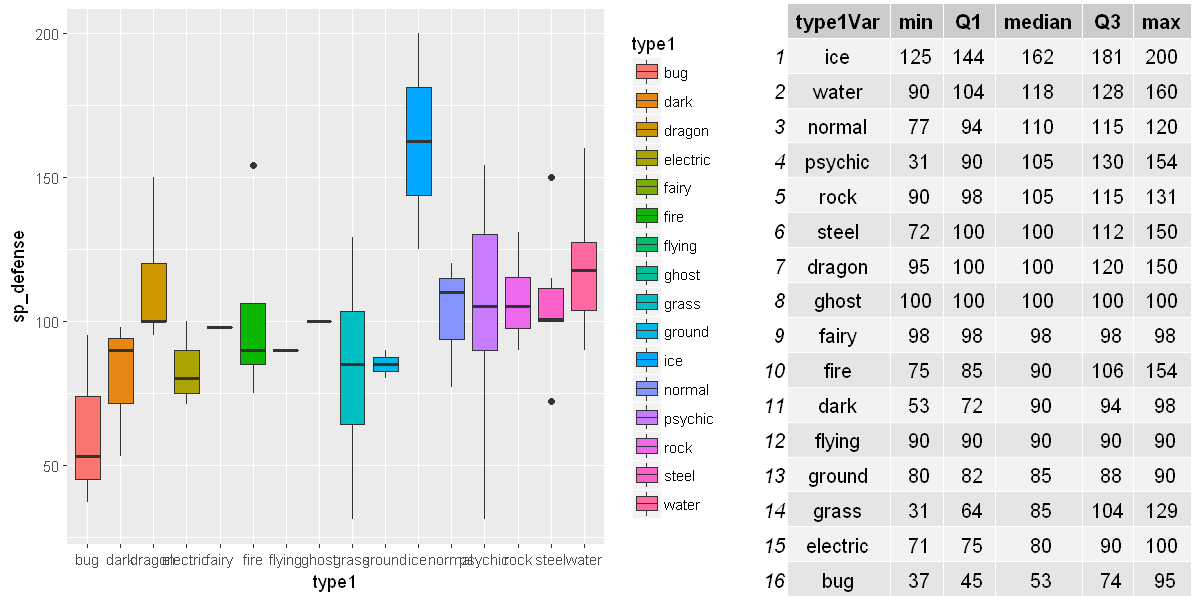

In [40]:
# barplot
p4_5_5 <- legend %>% 
  ggplot(aes(type1, sp_defense)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(sp_defense),
              Q1 = round(quantile(sp_defense)[2],0),
              median = round(quantile(sp_defense)[3],0),
              Q3 = round(quantile(sp_defense)[4],0),
              max = max(sp_defense))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_5 <- tableGrob(ndf)

grid.arrange(p4_5_5, t4_5_5, ncol = 2, widths = c(8,5))

### sp_defense(전설의 포켓몬)
- 중위수를 기준으로 ice 타입의 포켓몬(개체수 2)이 다른 능력치에 비해 높으며, bug 타입의 포켓몬(개체수 3)은 낮은 sp_defense을 보유하고 있다.
- ice 타입을 보유하고 있는 '레지아이스'가 sp_defense(200)의 높은 능력치를 보유하고 있다. 하지만 attack은 50으로 낮은 편이다.
- sp_defense가 가장 낮은 포켓몬은 psychic 타입과 더불어 [grass, steel] 타입의 포켓몬 '종이신도'이며, 그 다음으로 [bug, fighting] 타입의 포켓몬 '페로코체'가 낮은편에 속한다.
---
### 6. speed

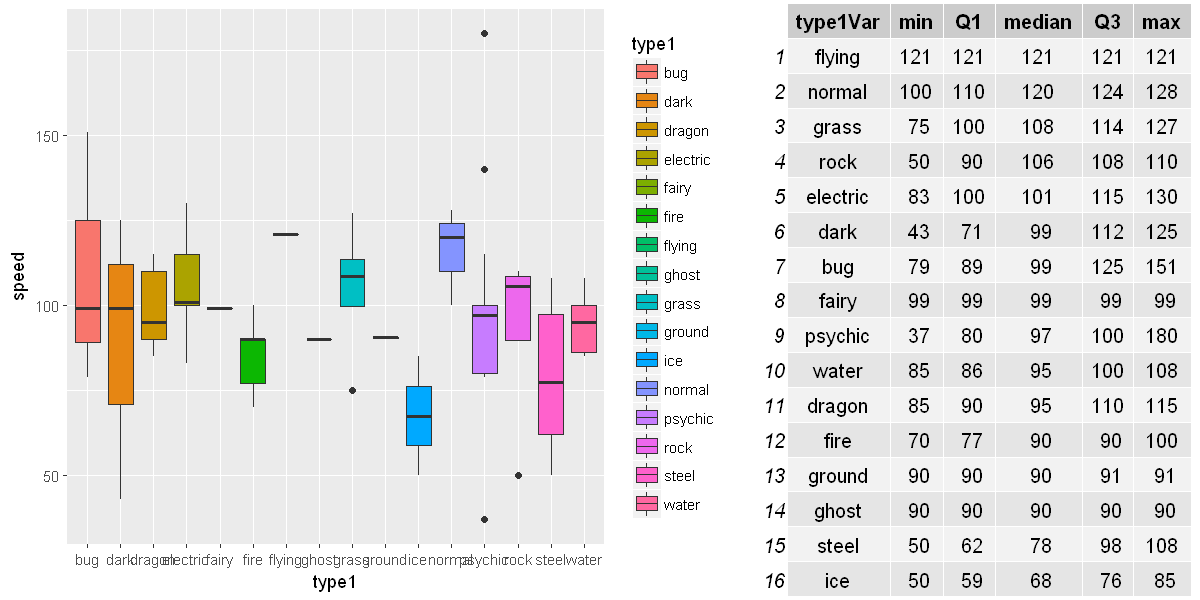

In [41]:
# barplot
p4_5_6 <- legend %>% 
  ggplot(aes(type1, speed)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(speed),
              Q1 = round(quantile(speed)[2],0),
              median = round(quantile(speed)[3],0),
              Q3 = round(quantile(speed)[4],0),
              max = max(speed))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_6 <- tableGrob(ndf)

grid.arrange(p4_5_6, t4_5_6, ncol = 2, widths = c(8,5))

### speed(전설의 포켓몬)
- 중위수를 기준으로 일반 포켓몬과 동일하게 flying 타입의 포켓몬(개체수 1)이 높으며, ice 타입의 포켓몬(개체수 3)은 낮은 speed를 보유하고 있다.
- psychic 타입을 보유하고 있는 '테오키스'가 가장 높은 speed(180)을 보유하고 있다. 테오키스의 다른 능력치는 speed의 절반 이하이다.
- speed가 가장 낮은 포켓몬도 psychic 타입의 포켓몬이다. 
---
### 7. base_total

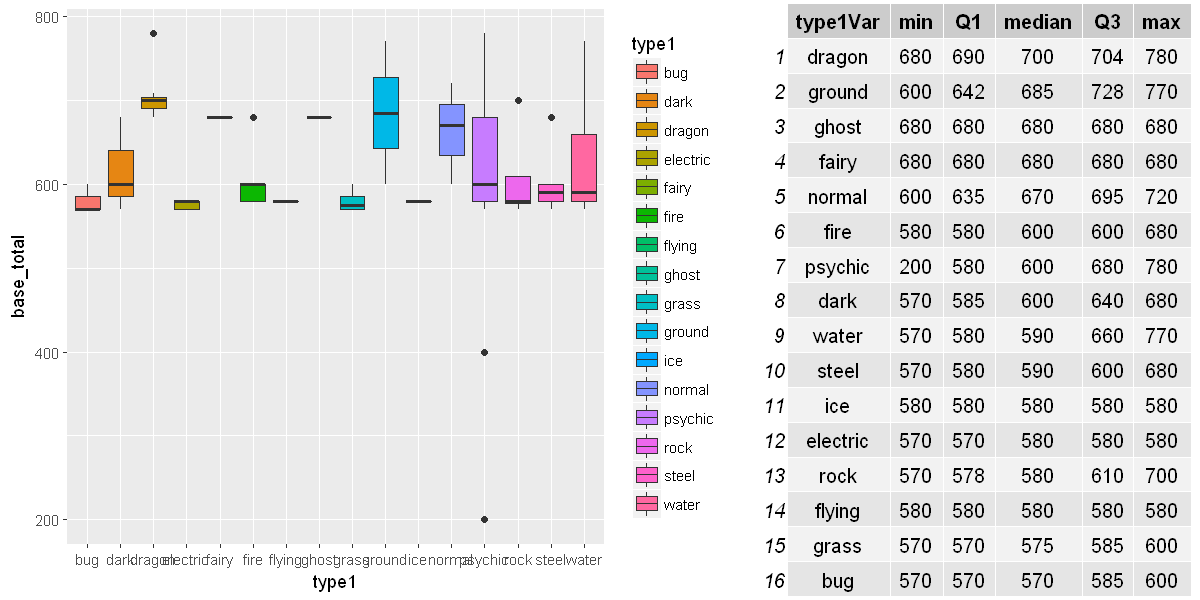

In [42]:
# barplot
p4_5_7 <- legend %>% 
  ggplot(aes(type1, base_total)) +
  geom_boxplot(aes(fill = type1)) 

# table (1사분위수, 중위수, 3사분위수)
type1Var <- unique(legend[, "type1"])
result <- c()
for(i in 1:length(type1Var)){
  temp <- legend %>% 
    filter(type1 == type1Var[i]) %>% 
    summarise(min = min(base_total),
              Q1 = round(quantile(base_total)[2],0),
              median = round(quantile(base_total)[3],0),
              Q3 = round(quantile(base_total)[4],0),
              max = max(base_total))
  result <- rbind(result, temp)
}
type1Var <- as.data.frame(type1Var)
result <- cbind(type1Var, result)
ndf <- result[order(-result$median),]
row.names(ndf) <- 1:nrow(ndf)
t4_5_7 <- tableGrob(ndf)

grid.arrange(p4_5_7, t4_5_7, ncol = 2, widths = c(8,5))

### base_total(전설의 포켓몬)
- 중위수를 기준으로 dragon 타입의 포켓몬(개체수 7)이 가장 높다.
- [dragon, flying] 타입을 보유하고 있는 '레쿠자'와 psychic 타입을 보유하고 있는 '뮤츠'가 가장 높은 base_total(780)을 보유하고 있다. 

---
### 결론) 
- dragon 타입의 포켓몬이 전체적으로 우수한 능력치를 보유한 포켓몬이다.
- psychic 타입의 포켓몬이 전체적으로 낮은 능력치를 보여준 이유는 <strong>'진화'</strong>와 관련되어 있다.<br /> 1세대부터 6세대 포켓몬까지는 진화가 가능한 전설의 포켓몬이 없었다. 하지만 7세대부터 코스모그 -> 코스모움 -> 솔가레오, 루나아라 형태로 <br />진화가 가능한 포켓몬이 생겼고 하위 단계 포켓몬 코스모그, 코스모움 때문에 psychic 타입의 포켓몬이 전체적인 능력치에서 min값이 가장 낮았다.

### type은 힘(hp, attack, defense), 지력(sp_attack, sp_defense), 민첩(speed)가 서로 연관성이 있다고 볼 수 있다. 
### 힘 타입과 지력 타입의 포켓몬은 서로 간의 카운터 역할을 하는 포켓몬으로 볼 수 있으며, <br />민첩이 높으면 포켓몬 배틀에서 선공을 가져갈 확률이 높다.

---
## 5) 상성 (against)
- against(상성)은 상대방 포켓몬의 기술을 방어할 때 받는 데미지의 비율이다.
- against가 0.5의 의미는 100데미지의 공격을 할 시 50의 데미지를 받는다.
- against가 4의 의미는 50 데미지의 공격을 할 시 200의 데미지를 받는다.
- 상성의 합이 낮을 수록 카운터 포켓몬이 적다고 생각할 수 있으므로 18개 타입들의 합을 계산

In [43]:
pokemon$against <- rowSums(pokemon[,23:40])
summary(pokemon$against)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.25   18.00   18.75   19.04   20.00   26.00 

In [44]:
pokemon %>% 
  filter(against == 13.25) %>% 
  select(name, type1, type2, against_poison, against_dragon, against_fight, against)

name,type1,type2,against_poison,against_dragon,against_fight,against
입치트,steel,fairy,0,0,1,13.25
클레피,steel,fairy,0,0,1,13.25
마기아나,steel,fairy,0,0,1,13.25


### 최고의 type 조합 : steel, fairy (약점이 보완되는 case)
- steel 타입 : posion 타입 공격 무효
- fairy 타입 : dragon 타입 공격 무효 (전체적으로 높은 능력치를 보유한 dragon타입 포켓몬의 카운터)
- steel의 약점 중 하나인 fighting 타입 공격 반감

In [45]:
pokemon %>% 
  filter(against == 26.00) %>% 
  select(name, type1, type2, against_fight, against_steel, against)

name,type1,type2,against_fight,against_steel,against
아마루스,rock,ice,4,4,26
아마루르가,rock,ice,4,4,26


### 최악의 type 조합 : rock, ice (약점이 강화되는 case)
- rock 타입과 ice 타입 각각 fight, steel에 2배로 공격 받는 약점을 보유하고 있다. 
- rock, ice 두가지 타입을 가질 경우 fight, steel에게 4배로 공격받음 

### 위에서 살펴본 (water, flying), (rock, water)의 타입 조합과 같은 case

---
## 6) 포획률(capture_rate)

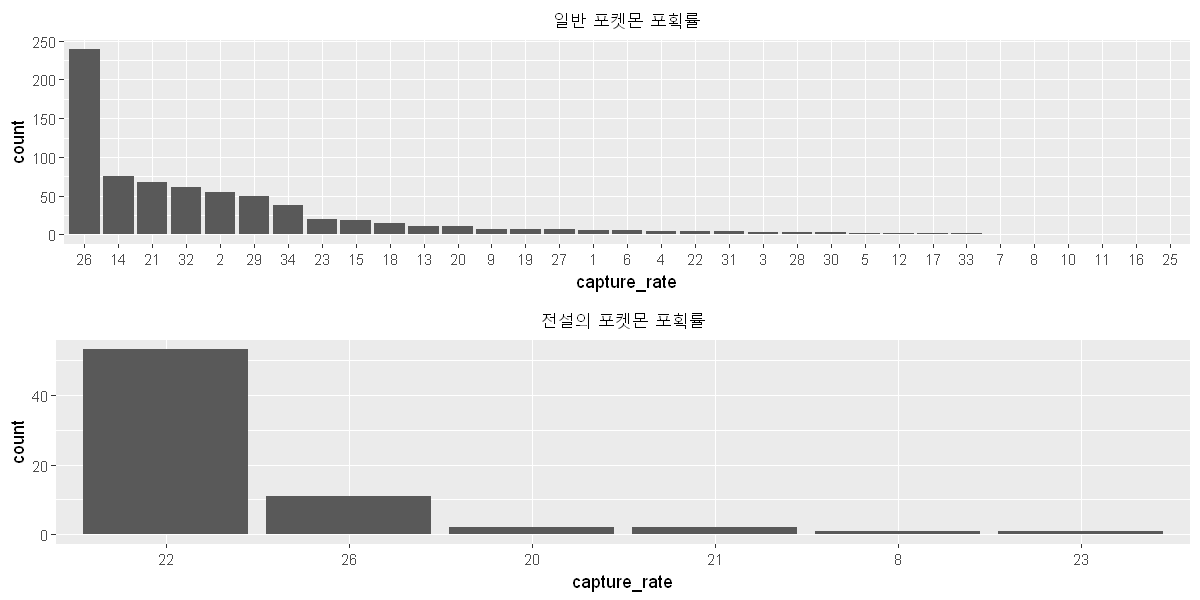

In [46]:
p6_1 <- normal %>% 
  group_by(capture_rate) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(capture_rate, -count), y = count)) +
  geom_bar(stat = "identity") + 
  ggtitle("일반 포켓몬 포획률") + 
  xlab("capture_rate") + 
  theme(plot.title = element_text(hjust = 0.5))

p6_2 <- legend %>% 
  group_by(capture_rate) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(capture_rate, -count), y = count)) +
  geom_bar(stat = "identity") + 
  ggtitle("전설의 포켓몬 포획률") + 
  xlab("capture_rate") + 
  theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p6_1, p6_2)

### 포획률(capture_rate)
- 3 ~ 255 범위로 존재하며 낮을수록 포획하기 힘듬
- 전설의 포켓몬 대부분이 포획률 3

---
## 7) 경험치(experience_growth)

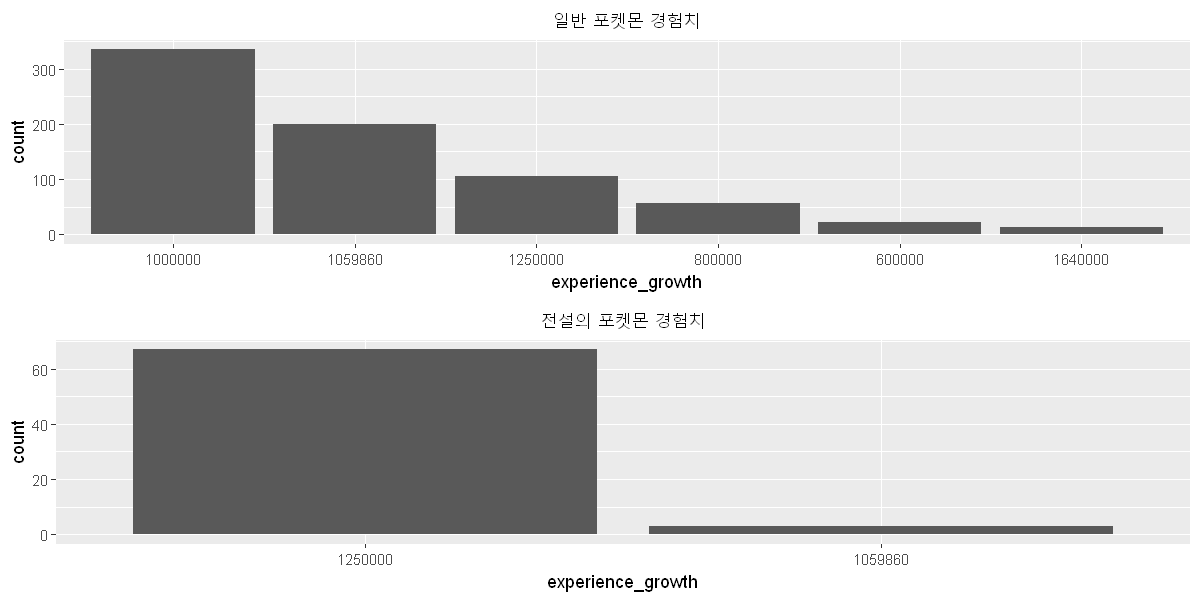

In [47]:
p7_1 <- normal %>% 
  group_by(experience_growth) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(experience_growth, -count), y = count)) +
  geom_bar(stat = "identity") + 
  ggtitle("일반 포켓몬 경험치") + 
  xlab("experience_growth") + 
  theme(plot.title = element_text(hjust = 0.5))

p7_2 <- legend %>% 
  group_by(experience_growth) %>% 
  summarise(count = n()) %>% 
  ggplot(aes(x = reorder(experience_growth, -count), y = count)) +
  geom_bar(stat = "identity") + 
  ggtitle("전설의 포켓몬 경험치") + 
  xlab("experience_growth") + 
  theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p7_1, p7_2)

### 경험치(experience_growth)
- 레벨 100까지 도달하기 위한 경험치
- 일반 포켓몬은 60,000 ~ 1,640,000 까지 골고루 분포되어 있으며 1,000,000이 가장 많다.
- 전설의 포켓몬 대부분은 1,250,000
---

## 3. Model
### 전설의 포켓몬과 일반 포켓몬을 분류하는 모델 생성
### 종속 변수(1개)
- is_legendary(전설 유무)

### 독립 변수(17개)
- generation(세대)
- type1, type2 (포켓몬 주, 서브 타입)
- hp, attack, defense, sp_attack, sp_defense, speed, base_total(능력치)
- capture_rate (포획률)
- height_m(키)
- weight_kg(몸무게)
- experience_growth(Level 100 필요 경험치)
- percentage_male(성비-수컷)
- base_egg_steps(알 부화 걸음수)
- base_happiness(행복도)
- against_ooo(상성) 18개


### 제외 변수
- podex_number(포켓몬 도감 번호) : key value
- name(포켓몬 이름) : key value
- classfication(포켓몬 분류) : 구세대 포켓몬 몇몇을 제외하고 특성에 맞게 새로운 분류명을 지어줌(ooo 포켓몬)
- abilities(특성)


In [48]:
noUseVar <- c("pokedex_number", "name", "classfication", "abilities", "type", "against")
modelData <- pokemon %>% 
  select(-one_of(noUseVar))

---
## 데이터 전처리
### 1) type1, type2 (포켓몬 주, 서브 타입)
#### 포켓몬 타입 character -> numeric(factor) 형태로 변환

In [49]:
# type1(주 타입) -> maintype
modelData <-  within(modelData,{
  maintype = numeric(0)
  maintype [ type1 == "" ] = 0
  maintype [ type1 == "bug" ] = 1
  maintype [ type1 == "dark" ] = 2
  maintype [ type1 == "dragon" ] = 3
  maintype [ type1 == "electric" ] = 4
  maintype [ type1 == "fairy" ] = 5
  maintype [ type1 == "fighting" ] = 6
  maintype [ type1 == "fire" ] = 7
  maintype [ type1 == "flying" ] = 8
  maintype [ type1 == "ghost" ] = 9
  maintype [ type1 == "grass" ] = 10
  maintype [ type1 == "ground" ] = 11
  maintype [ type1 == "ice" ] = 12
  maintype [ type1 == "normal" ] = 13
  maintype [ type1 == "poison" ] = 14
  maintype [ type1 == "psychic" ] = 15
  maintype [ type1 == "rock" ] = 16 
  maintype [ type1 == "steel" ] = 17
  maintype [ type1 == "water" ] = 18
  maintype = factor(maintype, level = c(0:18))
})

# type2(서브 타입) -> subtype
modelData <-  within(modelData,{
  subtype = numeric(0)
  subtype [ type2 == "" ] = 0
  subtype [ type2 == "bug" ] = 1
  subtype [ type2 == "dark" ] = 2
  subtype [ type2 == "dragon" ] = 3
  subtype [ type2 == "electric" ] = 4
  subtype [ type2 == "fairy" ] = 5
  subtype [ type2 == "fighting" ] = 6
  subtype [ type2 == "fire" ] = 7
  subtype [ type2 == "flying" ] = 8
  subtype [ type2 == "ghost" ] = 9
  subtype [ type2 == "grass" ] = 10
  subtype [ type2 == "ground" ] = 11
  subtype [ type2 == "ice" ] = 12
  subtype [ type2 == "normal" ] = 13
  subtype [ type2 == "poison" ] = 14
  subtype [ type2 == "psychic" ] = 15
  subtype [ type2 == "rock" ] = 16 
  subtype [ type2 == "steel" ] = 17
  subtype [ type2 == "water" ] = 18
  subtype = factor(subtype, level = 0:18)
})
modelData <- modelData %>% 
  select(-one_of(c("type1", "type2")))

---
### 2) capture_rate(포획률), height_m(키), weight_kg(몸무게), against_ooo(상성) 18개
- 수치형 데이터 표준화(scale)

In [50]:
ability <- colnames(modelData)[3:9]
againstVar <- colnames(modelData)[17:34]
scaleVar <- c(ability, againstVar, "capture_rate", "height_m", "weight_kg" )
scaleVar
modelData <- scale.features(modelData, scaleVar)

[1] "hp"               "attack"           "defense"          "sp_attack"       
 [5] "sp_defense"       "speed"            "base_total"       "against_bug"     
 [9] "against_dark"     "against_dragon"   "against_electric" "against_fairy"   
[13] "against_fight"    "against_fire"     "against_flying"   "against_ghost"   
[17] "against_grass"    "against_ground"   "against_ice"      "against_normal"  
[21] "against_poison"   "against_psychic"  "against_rock"     "against_steel"   
[25] "against_water"    "capture_rate"     "height_m"         "weight_kg"

---
### 3) percentage_male(성비-수컷)
- 무성인 포켓몬도 존재하기 때문에 성비가 있다, 없다(무성)으로 데이터 변환
- 무성(0) : 98
- 유성(1) : 703

In [51]:
modelData$percentage_male <- ifelse(is.na(modelData$percentage_male) == TRUE, 0, 1)
table(modelData$percentage_male)


  0   1 
 98 703 

---
### 4) experience_growth(Level 100 필요 경험치), base_egg_steps(알 부화 걸음수), base_happiness(행복도)
- 범주형 변수 : 등간성이 존재하지 않는 순위 변수
- pokemon 데이터는 전체 포켓몬을 나타내는 모집단이다. 
- 경험치, 알 부화 걸음수, 행복도는 포켓몬 도감에서 정해진 값들을 가지는 factor형태의 변수로 생각할 수 있다.

In [52]:
# experience_growth
table(modelData$experience_growth)
str(modelData$experience_growth)

# base_egg_steps
table(modelData$base_egg_steps)
str(modelData$base_egg_steps)

# base_happiness
table(modelData$base_happiness)
str(modelData$base_happiness)


 600000  800000 1000000 1059860 1250000 1640000 
     22      56     335     202     172      14 

 Factor w/ 6 levels "600000","800000",..: 4 4 4 4 4 4 4 4 4 3 ...



 1280  2560  3840  5120  6400  7680  8960 10240 20480 30720 
    2    22   140   436    55    26    13    42    16    49 

 Factor w/ 10 levels "1280","2560",..: 4 4 4 4 4 4 4 4 4 3 ...



  0  35  70  90 100 140 
 36  69 667   5  14  10 

 Factor w/ 6 levels "0","35","70",..: 3 3 3 3 3 3 3 3 3 3 ...


In [168]:
glimpse(modelData)

Observations: 801
Variables: 36
$ is_legendary      <fctr> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ generation        <fctr> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ hp                <dbl> -0.9015197, -0.3371010, 0.4154573, -1.1272872, -0...
$ attack            <dbl> -0.89734877, -0.49310509, 0.68853030, -0.80406177...
$ defense           <dbl> -0.78028583, -0.32528477, 1.62471975, -0.97528628...
$ sp_attack         <dbl> -0.1949033, 0.2687204, 1.5668667, -0.3494445, 0.2...
$ sp_defense        <dbl> -0.2115545, 0.3252622, 1.7567733, -0.7483711, -0....
$ speed             <dbl> -0.73802516, -0.21913159, 0.47272651, -0.04616706...
$ base_total        <dbl> -0.9259540, -0.1961101, 1.6494721, -1.0014551, -0...
$ capture_rate      <dbl> 0.48897616, 0.48897616, 0.48897616, 0.48897616, 0...
$ experience_growth <fctr> 1059860, 1059860, 1059860, 1059860, 1059860, 105...
$ height_m          <dbl> -0.42577197, -0.14538555, 0.78923584, -0.51923411...
$ weight_kg         

---
### 5) train / test 세트로 분리 

In [53]:
index <- sample(1:nrow(modelData), size = 0.6 * nrow(modelData)) 
trainData <- modelData[index, ]
testData <- modelData[-index, ]

---
## 특징 선택(feature selection)
- 랜덤 포레스트 모델을 통해 어떤 변수가 분류에 중요한 변수인지 확인

In [54]:
importanceRF <- feature.selection(feature.vars = trainData[, -1],
                                  class.var = trainData[, 1])

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



In [55]:
importanceRF
head(varImp(importanceRF))


Recursive feature selection

Outer resampling method: Cross-Validated (20 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.9898 0.9335    0.02237  0.1483         
         2   0.9898 0.9335    0.02237  0.1483         
         3   0.9876 0.9218    0.02370  0.1535         
         4   0.9856 0.9048    0.02398  0.1620         
         5   0.9877 0.9224    0.02329  0.1514         
         6   0.9898 0.9335    0.02237  0.1483         
         7   0.9918 0.9491    0.01693  0.1077        *
         8   0.9918 0.9491    0.01693  0.1077         
         9   0.9898 0.9335    0.02237  0.1483         
        10   0.9898 0.9335    0.02237  0.1483         
        35   0.9898 0.9335    0.02237  0.1483         

The top 5 variables (out of 7):
   base_egg_steps, percentage_male, base_happiness, base_total, capture_rate


,Overall
base_egg_steps,17.647132
percentage_male,12.056005
base_happiness,11.411453
base_total,11.344440
capture_rate,6.349645
experience_growth,6.141831


### 변수 개수가 7개일때 accuracy(정확도)가 0.992을 기록하고 있으며 변수가 늘어날 수록 accuracy(정확도)가 낮아진다.
### 중요도가 높은 top5 : base_egg_steps, percentage_male, base_happiness, base_total, capture_rate

---
## 모델 생성
### 1) Logistic Regression

In [56]:
# Logistic Regression
formulaInit <- "is_legendary ~ ."
formulaInit <- as.formula(formulaInit)
lrModel <- glm(formula = formulaInit, data = trainData, family = "binomial")
lrPredict <- predict(lrModel, testData, type = "response")
lrPredict <- round(lrPredict)
confusionMatrix(data = lrPredict, reference = testData[,1], positive = "1")

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 284   5
         1   8  24
                                          
               Accuracy : 0.9595          
                 95% CI : (0.9317, 0.9783)
    No Information Rate : 0.9097          
    P-Value [Acc > NIR] : 0.0004656       
                                          
                  Kappa : 0.7646          
 Mcnemar's Test P-Value : 0.5790997       
                                          
            Sensitivity : 0.82759         
            Specificity : 0.97260         
         Pos Pred Value : 0.75000         
         Neg Pred Value : 0.98270         
             Prevalence : 0.09034         
         Detection Rate : 0.07477         
   Detection Prevalence : 0.09969         
      Balanced Accuracy : 0.90009         
                                          
       'Positive' Class : 1               
                                          

### 35개 변수를 모두 사용
- Accuracy(정확도) : 0.960<br /> 전체 321마리 포켓몬 중 일반 포켓몬 284마리, 전설의 포켓몬 24마리가 정확하게 예측되어 정확도가 96%이다.
- sensitivity(민감도) : 0.828<br /> 전설의 포켓몬 29마리 중 24마리가 제대로 예측되어 민감도가 83%이다.
- specifictiy(특이도) : 0.973<br /> 일반 포켓몬 292마리 중 284마리가 제대로 예측되어 특이도가 97%이다.

### 다중공선성 확인

In [57]:
car::vif(lrModel)

ERROR: Error in vif.default(lrModel): there are aliased coefficients in the model


### 변수 개수가 많기 때문에 변수들 사이의 다중공선성 문제가 발생
### RF importance를 통해 확인한 중요도 top5변수를 사용하여 모델 생성

In [58]:
formulaInit <- "is_legendary ~ base_egg_steps + base_total + percentage_male + base_happiness + capture_rate"
formulaInit <- as.formula(formulaInit)
lrModel <- glm(formula = formulaInit, data = trainData, family = "binomial")
lrPredict <- predict(lrModel, testData, type = "response")
lrPredict <- round(lrPredict)
confusionMatrix(data = lrPredict, reference = testData[,1], positive = "1")
car::vif(lrModel)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 287   1
         1   5  28
                                          
               Accuracy : 0.9813          
                 95% CI : (0.9598, 0.9931)
    No Information Rate : 0.9097          
    P-Value [Acc > NIR] : 1.075e-07       
                                          
                  Kappa : 0.8929          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.96552         
            Specificity : 0.98288         
         Pos Pred Value : 0.84848         
         Neg Pred Value : 0.99653         
             Prevalence : 0.09034         
         Detection Rate : 0.08723         
   Detection Prevalence : 0.10280         
      Balanced Accuracy : 0.97420         
                                          
       'Positive' Class : 1               
                                          

,GVIF,Df,GVIF^(1/(2*Df))
base_egg_steps,1.296545e+18,9,10.145325
base_total,1.193636e+00,1,1.092536
percentage_male,3.284544e+07,1,5731.093991
base_happiness,1.007717e+18,5,63.144259
capture_rate,1.621465e+00,1,1.273367


### RF importance top5 변수를 사용한 결과 accuracy가 올라감
- Accuracy(정확도) : 0.981<br /> 전체 321마리 포켓몬 중 일반 포켓몬 287마리, 전설의 포켓몬 28마리가 정확하게 예측되어 정확도가 96%이다.
- sensitivity(민감도) : 0.966<br /> 전설의 포켓몬 29마리 중 28마리가 제대로 예측되어 민감도가 97%이다.
- specifictiy(특이도) : 0.982<br /> 일반 포켓몬 292마리 중 287마리가 제대로 예측되어 특이도가 98%이다.


---
## 2) SVM (Support Vector Machine)

In [59]:
# SVM
formulaInit <- "is_legendary ~ ."
formulaInit <- as.formula(formulaInit)
svmModel <- svm(formula = formulaInit, data = trainData, kernel = "radial", 
                cost = 100, gamma = 1)
svmPredict <- predict(svmModel, testData[,-1])
confusionMatrix(data = svmPredict, reference = testData[,1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 292  29
         1   0   0
                                          
               Accuracy : 0.9097          
                 95% CI : (0.8728, 0.9387)
    No Information Rate : 0.9097          
    P-Value [Acc > NIR] : 0.5492          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : 1.999e-07       
                                          
            Sensitivity : 0.00000         
            Specificity : 1.00000         
         Pos Pred Value :     NaN         
         Neg Pred Value : 0.90966         
             Prevalence : 0.09034         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : 1               
                                          

### Accuracy(정확도) : 0.901
- 전체 321마리 포켓몬 중 일반 포켓몬 292마리는 완벽하게 예측했지만, <strong>전설의 포켓몬 29마리는 한마리도 예측하지 못했다.</strong>

### SVM에 적합한 변수를 확인해서 사용
### 5-kold 2번 반복 -> svm모델 변수 importance 확인

In [60]:
control <- trainControl(method = "repeatedcv", number = 5, repeats = 2)
model <- train(formulaInit, data = trainData,
               method = "svmRadial", trcontrol = control)

Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."Warning message in .local(x, ...):
"Vari

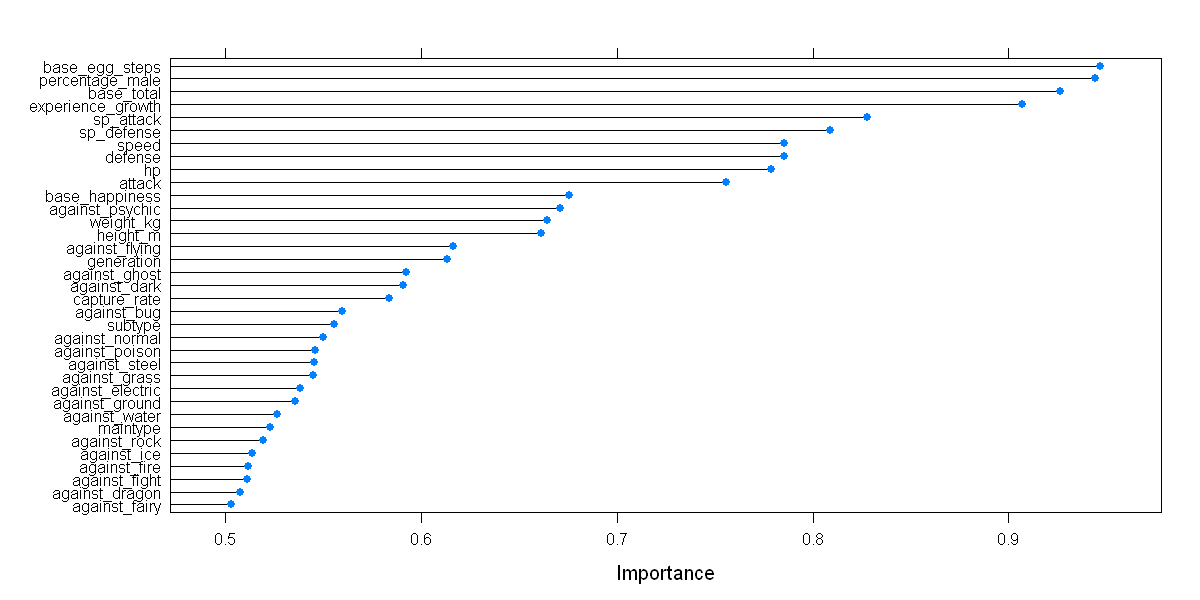

In [61]:
importance <- varImp(model, scale = FALSE)
plot(importance, cex.lab = 0.5)

### top5 변수를 활용한 SVM 모델 생성

In [62]:
svmFormulaInit <- "is_legendary ~ base_egg_steps + percentage_male + base_total + experience_growth + sp_attack"
svmFormulaInit <- as.formula(svmFormulaInit)
svmModel <- svm(formula = svmFormulaInit, data = trainData, kernel = "radial", 
                cost = 100, gamma = 1)
svmPredict <- predict(svmModel, testData[,-1])
confusionMatrix(data = svmPredict, reference = testData[,1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291   5
         1   1  24
                                          
               Accuracy : 0.9813          
                 95% CI : (0.9598, 0.9931)
    No Information Rate : 0.9097          
    P-Value [Acc > NIR] : 1.075e-07       
                                          
                  Kappa : 0.8787          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.82759         
            Specificity : 0.99658         
         Pos Pred Value : 0.96000         
         Neg Pred Value : 0.98311         
             Prevalence : 0.09034         
         Detection Rate : 0.07477         
   Detection Prevalence : 0.07788         
      Balanced Accuracy : 0.91208         
                                          
       'Positive' Class : 1               
                                          

### 5개 변수 사용 : 35개 변수를 사용한 로지스틱 회귀와 비슷한 성능을 보여준다.
- 일반 포켓몬 예측률이 올라감
- Accuracy(정확도) : 0.981<br /> 전체 321마리 포켓몬 중 일반 포켓몬 291마리, 전설의 포켓몬 24마리가 정확하게 예측되어 정확도가 98%이다.
- sensitivity(민감도) : 0.828<br /> 전설의 포켓몬 29마리 중 24마리가 제대로 예측되어 민감도가 83%이다.
- specifictiy(특이도) : 0.996<br /> 일반 포켓몬 292마리 중 291마리가 제대로 예측되어 특이도가 거의 100%에 가깝다.

### 하이퍼파라미터 튜닝

In [63]:
costWeights <- c(0.1, 10, 100)
gammaWeights <- c(0.01, 0.25, 0.5, 1)
tuningResults <- tune(svm, svmFormulaInit, data = trainData, kerner = "radial")
svmBestModel <- tuningResults$best.model
svmPredictBest <- predict(svmBestModel, testData[, -1])
confusionMatrix(data = svmPredictBest, reference = testData[, 1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291   4
         1   1  25
                                         
               Accuracy : 0.9844         
                 95% CI : (0.964, 0.9949)
    No Information Rate : 0.9097         
    P-Value [Acc > NIR] : 1.981e-08      
                                         
                  Kappa : 0.9006         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.86207        
            Specificity : 0.99658        
         Pos Pred Value : 0.96154        
         Neg Pred Value : 0.98644        
             Prevalence : 0.09034        
         Detection Rate : 0.07788        
   Detection Prevalence : 0.08100        
      Balanced Accuracy : 0.92932        
                                         
       'Positive' Class : 1              
                                         

### 5개 변수 사용 + 하이퍼파라미터 튜닝
- Accuracy(정확도) : 0.984<br /> 전체 321마리 포켓몬 중 일반 포켓몬 291마리, 전설의 포켓몬 25마리가 정확하게 예측되어 정확도가 98%이다.
- sensitivity(민감도) : 0.862<br /> 전설의 포켓몬 29마리 중 24마리가 제대로 예측되어 민감도가 86%이다.
- specifictiy(특이도) : 0.996<br /> 일반 포켓몬 292마리 중 291마리가 제대로 예측되어 특이도가 거의 100%에 가깝다.


---
### 3) Decision Tree

In [64]:
# Decision Tree
formulaInit <- "is_legendary ~ ."
formulaInit <- as.formula(formulaInit)
dtModel <- rpart(formula = formulaInit, method = "class",data = trainData, 
                  control = rpart.control(minsplit = 20, cp = 0.05))
dtPredict <- predict(dtModel, testData[, -1], type = "class")
confusionMatrix(data = dtPredict, reference = testData[, 1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291   4
         1   1  25
                                         
               Accuracy : 0.9844         
                 95% CI : (0.964, 0.9949)
    No Information Rate : 0.9097         
    P-Value [Acc > NIR] : 1.981e-08      
                                         
                  Kappa : 0.9006         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.86207        
            Specificity : 0.99658        
         Pos Pred Value : 0.96154        
         Neg Pred Value : 0.98644        
             Prevalence : 0.09034        
         Detection Rate : 0.07788        
   Detection Prevalence : 0.08100        
      Balanced Accuracy : 0.92932        
                                         
       'Positive' Class : 1              
                                         

### 5개 변수 사용 + 하이퍼파라미터 튜닝을 거친 SVM 모델과 동일한 성능을 보인다.
### 5-fold cross validation(2회 반복)을 통해 Decision Tree 모델 변수의 importance를 확인

In [65]:
control <- trainControl(method = "repeatedcv", number = 5, repeats = 2)
model <- train(formulaInit, data = trainData, method = "rpart", 
               trControl=control)
importance <- varImp(model, scale=FALSE)
importance

rpart variable importance

  only 20 most important variables shown (out of 90)

                         Overall
percentage_male            56.34
base_total                 49.00
base_egg_steps30720        45.93
base_happiness70           42.48
experience_growth1250000   29.44
base_egg_steps20480        21.17
against_steel               0.00
subtype2                    0.00
generation2                 0.00
experience_growth1059860    0.00
subtype16                   0.00
sp_attack                   0.00
against_bug                 0.00
maintype18                  0.00
subtype15                   0.00
maintype11                  0.00
height_m                    0.00
subtype6                    0.00
maintype15                  0.00
subtype7                    0.00

In [66]:
formulaInit <- "is_legendary ~ percentage_male + base_total + base_egg_steps + base_happiness + experience_growth"
formulaInit <- as.formula(formulaInit)
dtModel <- rpart(formula = formulaInit, method = "class", data = trainData, 
                      control = rpart.control(minsplit = 20, cp = 0.05),
                      parms = list(prior = c(0.7, 0.3)))
dtPredict <- predict(dtModel, testData[, -1], type = "class")
confusionMatrix(data = dtPredict, reference = testData[, 1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 279   4
         1  13  25
                                          
               Accuracy : 0.947           
                 95% CI : (0.9166, 0.9689)
    No Information Rate : 0.9097          
    P-Value [Acc > NIR] : 0.008837        
                                          
                  Kappa : 0.7173          
 Mcnemar's Test P-Value : 0.052345        
                                          
            Sensitivity : 0.86207         
            Specificity : 0.95548         
         Pos Pred Value : 0.65789         
         Neg Pred Value : 0.98587         
             Prevalence : 0.09034         
         Detection Rate : 0.07788         
   Detection Prevalence : 0.11838         
      Balanced Accuracy : 0.90877         
                                          
       'Positive' Class : 1               
                                          

### DT importance top5 변수를 사용했을때 accuracy(정확도)가 더 낮아진다.
- Accuracy(정확도) : 0.947<br /> 전체 321마리 포켓몬 중 일반 포켓몬 279마리, 전설의 포켓몬 25마리가 정확하게 예측되어 정확도가 95%이다.
- sensitivity(민감도) : 0.862<br /> 전설의 포켓몬 29마리 중 25마리가 제대로 예측되어 민감도가 86%이다.
- specifictiy(특이도) : 0.955<br /> 일반 포켓몬 292마리 중 279마리가 제대로 예측되어 특이도가 96%이다.

---
## 4) Random Forest

In [67]:
# Random Forest
formulaInit <- "is_legendary ~ ."
formulaInit <- as.formula(formulaInit)
rfModel <- randomForest(formulaInit, data = trainData, importance = T, proximity = T)
rfPredict <- predict(rfModel, testData[, -1], type="class")
confusionMatrix(data=rfPredict, reference=testData[, 1], positive="1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291   4
         1   1  25
                                         
               Accuracy : 0.9844         
                 95% CI : (0.964, 0.9949)
    No Information Rate : 0.9097         
    P-Value [Acc > NIR] : 1.981e-08      
                                         
                  Kappa : 0.9006         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.86207        
            Specificity : 0.99658        
         Pos Pred Value : 0.96154        
         Neg Pred Value : 0.98644        
             Prevalence : 0.09034        
         Detection Rate : 0.07788        
   Detection Prevalence : 0.08100        
      Balanced Accuracy : 0.92932        
                                         
       'Positive' Class : 1              
                                         

### 5개 변수 사용 + 하이퍼파라미터 튜닝을 거친 SVM 모델, 35변수 사용 Decision Tree와 동일한 성능을 보인다.
### RF importance top5 변수 + 하이퍼파라미터 튜닝

In [68]:
# RF importance top5 변수
formulaInit <- "is_legendary ~ base_egg_steps + percentage_male + base_happiness + base_total + capture_rate"
formulaInit <- as.formula(formulaInit)

# 하이퍼파라미터 튜닝
nodesizeVals <- c(2, 3, 4, 5)
ntreeVals <- c(200, 500, 1000, 2000)
tuningResults <- tune.randomForest(formulaInit, 
                                    data = trainData,
                                    mtry = 3, 
                                    nodesize = nodesizeVals,
                                    ntree = ntreeVals)
rfBestModel <- tuningResults$best.model
rfPredictiBest <- predict(rfBestModel, testData[, -1], type = "class")
confusionMatrix(data = rfPredictiBest, reference = testData[, 1], positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 291   4
         1   1  25
                                         
               Accuracy : 0.9844         
                 95% CI : (0.964, 0.9949)
    No Information Rate : 0.9097         
    P-Value [Acc > NIR] : 1.981e-08      
                                         
                  Kappa : 0.9006         
 Mcnemar's Test P-Value : 0.3711         
                                         
            Sensitivity : 0.86207        
            Specificity : 0.99658        
         Pos Pred Value : 0.96154        
         Neg Pred Value : 0.98644        
             Prevalence : 0.09034        
         Detection Rate : 0.07788        
   Detection Prevalence : 0.08100        
      Balanced Accuracy : 0.92932        
                                         
       'Positive' Class : 1              
                                         

### 기존의 모델과 성능 차이가 보이지 않는다.
---
# 결론

| | Logistic Regression | Support Vector Machine | Decision Tree | Random Forest |
| :------------: | :-----------: | :------------: | :------------: | :------------: |
| Accuracy     | 96% | 98% | 95% | 98% |
| Sensitivity  | 97% | 86% | 86% | 86% |
| Specificity  | 98% | 100% | 96% | 100% |

### Accuracy(정확도)는 Support Vector Machine과 Random Forest가 98%로 가장 높지만 <br />Sensitivity(민감도)가 86%이므로 전설의 포켓몬을 제대로 분류하지 못했다.
### 두 모델에 비해 Accuracy(정확도) 는 96%이지만 Sensitivity(민감도)가 97%인 Logistic Regression 모델이 전체 전설의 포켓몬 29마리중 28마리를 분류 함으로써 가장 좋은 성능을 보여주었다.
### 비지니스 관점에 따라 confusionMatrix의 다른 값들과 비교 분석해야 하지만, 해당 포켓몬 도감 데이터에서는 전설의 포켓몬 분류가 목적이기 때문에 <font color = "red">RF imptance top5 변수를 사용한 Logistic Regression이 가장 우수한 모델</font>로 생각할 수 있다.





<br/ >
#  <center> 긴 글 읽어주셔서 감사합니다.</center>